<a href="https://colab.research.google.com/github/Debdeep23/transformer-interpretability/blob/main/Transformer_Interpretability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Running in Google Colab - Auto-download functionality enabled!
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully for backup!

   PICO-LLM: ENHANCED INTERPRETABILITY ANALYSIS   

IMPORTANT: Running in Google Colab environment.
Files will be automatically downloaded to your local computer
at key points to prevent data loss when Colab disconnects.
Global tokenizer: GPT-2 (Vocab: 50257, EOT: 50256)
ExperimentTracker: Results in 'pico_llm_interpretability_experiments'
Device: cuda

Pipeline Options:
  1. Pre-train Base Transformer Model
  2. Run Enhanced Interpretability Analysis
  3. Run BOTH: Pre-train then Analyze
Enter your choice (1-3): 3

--- ACTION: Pre-training Base Model and Running Analysis ---

Step 1: Pre-training Base Model...

STARTING BASE PRE-TRAINING on wikitext (Concatenated)
Before base data load GPU memory: Allocated=0.0MB, Reserved=0.0MB
Loading & Concatenati

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/722k [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/156M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/156M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/655k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1801350 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Tokenizing and concatenating dataset...


Tokenizing wikitext:   0%|          | 0/360270 [00:00<?, ?it/s]

Created 45363 sequences for pre-training from concatenated wikitext.
Tracker: Config for 'PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001' recorded.

Starting base pre-train (Exp:PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001). 2836 batches/epoch.
Before base train loop GPU memory: Allocated=272.1MB, Reserved=284.0MB
Train 'PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001' 10ep on cuda. Eff.BatchSz:32. LR(max):0.0001. Steps ~14180. Warmup:850. Exp:'PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001'


Ep 1/10 (Exp:PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001):   0%|          | 0/2836 [00:00<?, ?it…


[PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001] Sampling...
Sample:The meaning of life is Robb compat RodgersateursRobertsleadersberger Ecworstmassive Morelest Goal cartel concerns learning conditioning housing foll wear closure Zh32monehorse AmpWould referrals Grab grade Float Checks AmespletosureImprovedossalBoot poopxi treacherous negotiations biblical hyd smiling Sports air Amidopathumbing

[PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001] Ep 1,St 200/2836(Glob:200)|Loss:10.1051|LR:1.18e-05
St 200 GPU memory: Allocated=2669.1MB, Reserved=13860.0MB

[PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001] Ep 1,St 400/2836(Glob:400)|Loss:8.6729|LR:2.35e-05
St 400 GPU memory: Allocated=2669.1MB, Reserved=13860.0MB

[PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001] Ep 1,St 600/2836(Glob:600)|Loss:7.3978|LR:3.53e-05
St 600 GPU memory: Allocated=2669.1MB, Reserved=13860.0MB

[PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001] Ep 1,St 800/2836(G

Ep 2/10 (Exp:PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001):   0%|          | 0/2836 [00:00<?, ?it…


[PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001] Ep 2,St 164/2836(Glob:3000)|Loss:5.4270|LR:9.94e-05
St 3000 GPU memory: Allocated=2669.1MB, Reserved=16016.0MB

[PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001] Ep 2,St 364/2836(Glob:3200)|Loss:5.4303|LR:9.92e-05
St 3200 GPU memory: Allocated=2669.1MB, Reserved=16016.0MB

[PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001] Ep 2,St 564/2836(Glob:3400)|Loss:5.1547|LR:9.90e-05
St 3400 GPU memory: Allocated=2669.1MB, Reserved=16016.0MB

[PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001] Ep 2,St 764/2836(Glob:3600)|Loss:5.3400|LR:9.88e-05
St 3600 GPU memory: Allocated=2669.1MB, Reserved=16016.0MB

[PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001] Ep 2,St 964/2836(Glob:3800)|Loss:5.2833|LR:9.85e-05
St 3800 GPU memory: Allocated=2669.1MB, Reserved=16016.0MB

[PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001] Ep 2,St 1164/2836(Glob:4000)|Loss:5.2497|LR:9.82e-05
St 4000 GPU memory: Alloca

Ep 3/10 (Exp:PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001):   0%|          | 0/2836 [00:00<?, ?it…


[PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001] Ep 3,St 128/2836(Glob:5800)|Loss:4.8080|LR:9.43e-05
St 5800 GPU memory: Allocated=2669.1MB, Reserved=16022.0MB

[PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001] Ep 3,St 328/2836(Glob:6000)|Loss:4.8681|LR:9.37e-05
St 6000 GPU memory: Allocated=2669.1MB, Reserved=16022.0MB

[PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001] Ep 3,St 528/2836(Glob:6200)|Loss:4.9377|LR:9.31e-05
St 6200 GPU memory: Allocated=2669.1MB, Reserved=16022.0MB

[PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001] Ep 3,St 728/2836(Glob:6400)|Loss:4.7813|LR:9.25e-05
St 6400 GPU memory: Allocated=2669.1MB, Reserved=16022.0MB

[PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001] Ep 3,St 928/2836(Glob:6600)|Loss:4.8912|LR:9.19e-05
St 6600 GPU memory: Allocated=2669.1MB, Reserved=16022.0MB

[PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001] Ep 3,St 1128/2836(Glob:6800)|Loss:4.7946|LR:9.12e-05
St 6800 GPU memory: Alloca

Ep 4/10 (Exp:PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001):   0%|          | 0/2836 [00:00<?, ?it…


[PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001] Ep 4,St 92/2836(Glob:8600)|Loss:4.6840|LR:8.44e-05
St 8600 GPU memory: Allocated=2669.1MB, Reserved=16016.0MB

[PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001] Ep 4,St 292/2836(Glob:8800)|Loss:4.7435|LR:8.35e-05
St 8800 GPU memory: Allocated=2669.1MB, Reserved=16016.0MB

[PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001] Ep 4,St 492/2836(Glob:9000)|Loss:4.5415|LR:8.26e-05
St 9000 GPU memory: Allocated=2669.1MB, Reserved=16016.0MB

[PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001] Ep 4,St 692/2836(Glob:9200)|Loss:4.4574|LR:8.17e-05
St 9200 GPU memory: Allocated=2669.1MB, Reserved=16016.0MB

[PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001] Ep 4,St 892/2836(Glob:9400)|Loss:4.2411|LR:8.08e-05
St 9400 GPU memory: Allocated=2669.1MB, Reserved=16016.0MB

[PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001] Ep 4,St 1092/2836(Glob:9600)|Loss:4.3612|LR:7.99e-05
St 9600 GPU memory: Allocat

Ep 5/10 (Exp:PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001):   0%|          | 0/2836 [00:00<?, ?it…


[PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001] Ep 5,St 56/2836(Glob:11400)|Loss:4.3931|LR:7.07e-05
St 11400 GPU memory: Allocated=2669.1MB, Reserved=16022.0MB

[PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001] Ep 5,St 256/2836(Glob:11600)|Loss:4.3744|LR:6.97e-05
St 11600 GPU memory: Allocated=2669.1MB, Reserved=16022.0MB

[PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001] Ep 5,St 456/2836(Glob:11800)|Loss:4.2115|LR:6.86e-05
St 11800 GPU memory: Allocated=2669.1MB, Reserved=16022.0MB

[PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001] Ep 5,St 656/2836(Glob:12000)|Loss:4.2252|LR:6.75e-05
St 12000 GPU memory: Allocated=2669.1MB, Reserved=16022.0MB

[PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001] Ep 5,St 856/2836(Glob:12200)|Loss:4.2164|LR:6.64e-05
St 12200 GPU memory: Allocated=2669.1MB, Reserved=16022.0MB

[PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001] Ep 5,St 1056/2836(Glob:12400)|Loss:4.3597|LR:6.52e-05
St 12400 GPU mem

Ep 6/10 (Exp:PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001):   0%|          | 0/2836 [00:00<?, ?it…


[PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001] Ep 6,St 20/2836(Glob:14200)|Loss:4.0513|LR:5.49e-05
St 14200 GPU memory: Allocated=2669.1MB, Reserved=16016.0MB

[PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001] Ep 6,St 220/2836(Glob:14400)|Loss:4.2336|LR:5.37e-05
St 14400 GPU memory: Allocated=2669.1MB, Reserved=16016.0MB

[PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001] Ep 6,St 420/2836(Glob:14600)|Loss:4.2680|LR:5.25e-05
St 14600 GPU memory: Allocated=2669.1MB, Reserved=16016.0MB

[PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001] Ep 6,St 620/2836(Glob:14800)|Loss:4.0658|LR:5.14e-05
St 14800 GPU memory: Allocated=2669.1MB, Reserved=16016.0MB

[PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001] Ep 6,St 820/2836(Glob:15000)|Loss:4.1872|LR:5.02e-05
St 15000 GPU memory: Allocated=2669.1MB, Reserved=16016.0MB

[PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001] Ep 6,St 1020/2836(Glob:15200)|Loss:4.2149|LR:4.90e-05
St 15200 GPU mem

Ep 7/10 (Exp:PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001):   0%|          | 0/2836 [00:00<?, ?it…


[PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001] Ep 7,St 184/2836(Glob:17200)|Loss:3.8785|LR:3.74e-05
St 17200 GPU memory: Allocated=2670.4MB, Reserved=16004.0MB

[PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001] Ep 7,St 384/2836(Glob:17400)|Loss:4.2117|LR:3.62e-05
St 17400 GPU memory: Allocated=2670.4MB, Reserved=16004.0MB

[PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001] Ep 7,St 584/2836(Glob:17600)|Loss:4.0927|LR:3.51e-05
St 17600 GPU memory: Allocated=2670.4MB, Reserved=16004.0MB

[PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001] Ep 7,St 784/2836(Glob:17800)|Loss:3.9871|LR:3.40e-05
St 17800 GPU memory: Allocated=2670.4MB, Reserved=16004.0MB

[PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001] Ep 7,St 984/2836(Glob:18000)|Loss:4.2886|LR:3.29e-05
St 18000 GPU memory: Allocated=2670.4MB, Reserved=16004.0MB

[PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001] Ep 7,St 1184/2836(Glob:18200)|Loss:3.9492|LR:3.18e-05
St 18200 GPU me

Ep 8/10 (Exp:PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001):   0%|          | 0/2836 [00:00<?, ?it…


[PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001] Ep 8,St 148/2836(Glob:20000)|Loss:3.9288|LR:2.24e-05
St 20000 GPU memory: Allocated=2670.9MB, Reserved=15992.0MB

[PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001] Ep 8,St 348/2836(Glob:20200)|Loss:4.1287|LR:2.14e-05
St 20200 GPU memory: Allocated=2670.9MB, Reserved=15992.0MB

[PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001] Ep 8,St 548/2836(Glob:20400)|Loss:4.1537|LR:2.04e-05
St 20400 GPU memory: Allocated=2670.9MB, Reserved=15992.0MB

[PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001] Ep 8,St 748/2836(Glob:20600)|Loss:4.0837|LR:1.95e-05
St 20600 GPU memory: Allocated=2670.9MB, Reserved=15992.0MB

[PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001] Sampling...
Sample:The meaning of life is about to date in the days of his death . The earliest mention of the life of the " death of a woman " is derived from the poet 's death . The " <unk> " , where , after being " <unk> " ,

[PRETRAIN_CONC

Ep 9/10 (Exp:PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001):   0%|          | 0/2836 [00:00<?, ?it…


[PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001] Ep 9,St 112/2836(Glob:22800)|Loss:4.0146|LR:1.04e-05
St 22800 GPU memory: Allocated=2670.9MB, Reserved=15992.0MB

[PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001] Ep 9,St 312/2836(Glob:23000)|Loss:3.9949|LR:9.65e-06
St 23000 GPU memory: Allocated=2670.9MB, Reserved=15992.0MB

[PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001] Ep 9,St 512/2836(Glob:23200)|Loss:4.0096|LR:8.96e-06
St 23200 GPU memory: Allocated=2670.9MB, Reserved=15992.0MB

[PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001] Ep 9,St 712/2836(Glob:23400)|Loss:4.1419|LR:8.30e-06
St 23400 GPU memory: Allocated=2670.9MB, Reserved=15992.0MB

[PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001] Ep 9,St 912/2836(Glob:23600)|Loss:4.1848|LR:7.66e-06
St 23600 GPU memory: Allocated=2670.9MB, Reserved=15992.0MB

[PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001] Ep 9,St 1112/2836(Glob:23800)|Loss:3.9282|LR:7.05e-06
St 23800 GPU me

Ep 10/10 (Exp:PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001):   0%|          | 0/2836 [00:00<?, ?i…


[PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001] Ep 10,St 76/2836(Glob:25600)|Loss:4.0134|LR:5.00e-06
St 25600 GPU memory: Allocated=2670.9MB, Reserved=15992.0MB

[PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001] Sampling...
Sample:The meaning of life is one of the last surviving trees , and can be seen from the middle of the past . The gill is divided into two crescent layers . The surrounding outer layer of the central front , the paler and the inner part of the body are the

[PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001] Ep 10,St 276/2836(Glob:25800)|Loss:3.8717|LR:5.00e-06
St 25800 GPU memory: Allocated=2669.1MB, Reserved=14378.0MB

[PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001] Ep 10,St 476/2836(Glob:26000)|Loss:3.7365|LR:5.00e-06
St 26000 GPU memory: Allocated=2669.1MB, Reserved=14378.0MB

[PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001] Ep 10,St 676/2836(Glob:26200)|Loss:3.9559|LR:5.00e-06
St 26200 GPU memory: Allocated=

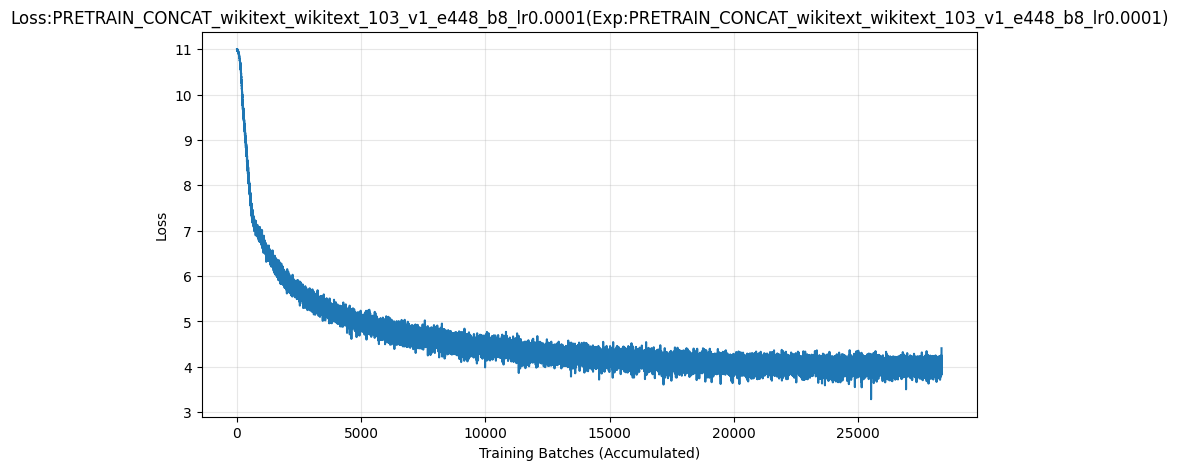

Saved latest model checkpoint to pico_llm_interpretability_experiments/PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001/model_checkpoint_latest.pt

COMPRESSING RESULTS FOR DOWNLOAD: pico_llm_checkpoint_PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001_20250511_154841.zip
  adding: pico_llm_interpretability_experiments/ (stored 0%)
  adding: pico_llm_interpretability_experiments/PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001/ (stored 0%)
  adding: pico_llm_interpretability_experiments/PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001/config.json (deflated 54%)
  adding: pico_llm_interpretability_experiments/PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001/model_checkpoint_latest.pt (deflated 7%)
  adding: pico_llm_interpretability_experiments/PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001/run_loss_curve.png (deflated 10%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Download initiated for pico_llm_checkpoint_PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001_20250511_154841.zip
If the download dialog doesn't appear, check your browser's download settings
or look for the file in your downloads folder.

Backup also saved to Google Drive: /content/drive/MyDrive/pico_llm_backups/pico_llm_checkpoint_PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001_20250511_154841.zip
Saved base model to 'results/base_transformer_for_interpretability.pt'

COMPRESSING RESULTS FOR DOWNLOAD: pico_llm_base_model_20250511_154858.zip
  adding: results/ (stored 0%)
  adding: results/base_transformer_for_interpretability.pt (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Download initiated for pico_llm_base_model_20250511_154858.zip
If the download dialog doesn't appear, check your browser's download settings
or look for the file in your downloads folder.

Backup also saved to Google Drive: /content/drive/MyDrive/pico_llm_backups/pico_llm_base_model_20250511_154858.zip
After base pre-train GPU memory: Allocated=558.7MB, Reserved=2464.0MB

Available test sentence categories:
  1. Simple Sentences
  2. Complex Syntax
  3. Long-Range Dependencies
  4. Coreference Resolution
  5. Negation
  6. Questions
  7. Technical Content
  8. Ambiguous Sentences
  9. Comparisons
  10. Temporal Sequences
Enter category numbers to use (comma-separated, empty for all): 

Step 2: Running Enhanced Interpretability Analysis...

RUNNING COMPREHENSIVE ATTENTION ANALYSIS: base_transformer_for_interpretability

Analyzing sentence 1/10: The cat sat on the mat....
  Creating visualizations for 7 interesting heads...

Analyzing sentence 2/10: The student who studied hard for the 

<ipython-input-5-b39bb2189e68>:935: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12, 10))
<ipython-input-5-b39bb2189e68>:749: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(fig_size, fig_size))



Analyzing sentence 6/10: What is the capital of France?...
  Creating visualizations for 5 interesting heads...

Analyzing sentence 7/10: Transformers use self-attention mechanisms to weig...
  Creating visualizations for 4 interesting heads...

Analyzing sentence 8/10: The professor lectured on the topic with enthusias...
  Creating visualizations for 6 interesting heads...

Analyzing sentence 9/10: This book is better than that one....
  Creating visualizations for 5 interesting heads...

Analyzing sentence 10/10: First, preheat the oven, then prepare the ingredie...
  Creating visualizations for 2 interesting heads...

Creating cross-sentence analysis visualizations...
Created interpretability report at pico_llm_interpretability_experiments/attention_visualizations/base_transformer_for_interpretability/interpretability_report.md

Comprehensive attention analysis complete!
Report: pico_llm_interpretability_experiments/attention_visualizations/base_transformer_for_interpretability/in

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Download initiated for pico_llm_visualizations_base_transformer_for_interpretability_20250511_160934.zip
If the download dialog doesn't appear, check your browser's download settings
or look for the file in your downloads folder.

Backup also saved to Google Drive: /content/drive/MyDrive/pico_llm_backups/pico_llm_visualizations_base_transformer_for_interpretability_20250511_160934.zip

Analysis complete! Downloading all results...

COMPRESSING RESULTS FOR DOWNLOAD: pico_llm_complete_results_20250511_160934.zip
  adding: pico_llm_interpretability_experiments/ (stored 0%)
  adding: pico_llm_interpretability_experiments/PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001/ (stored 0%)
  adding: pico_llm_interpretability_experiments/PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001/config.json (deflated 54%)
  adding: pico_llm_interpretability_experiments/PRETRAIN_CONCAT_wikitext_wikitext_103_v1_e448_b8_lr0.0001/model_checkpoint_latest.pt (deflated 7%)
  adding: pico_llm_inte

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Download initiated for pico_llm_complete_results_20250511_160934.zip
If the download dialog doesn't appear, check your browser's download settings
or look for the file in your downloads folder.

Backup also saved to Google Drive: /content/drive/MyDrive/pico_llm_backups/pico_llm_complete_results_20250511_160934.zip

Generating final reports (if any training was done)...
Tracker: Saved loss plot to pico_llm_interpretability_experiments/all_training_loss.png


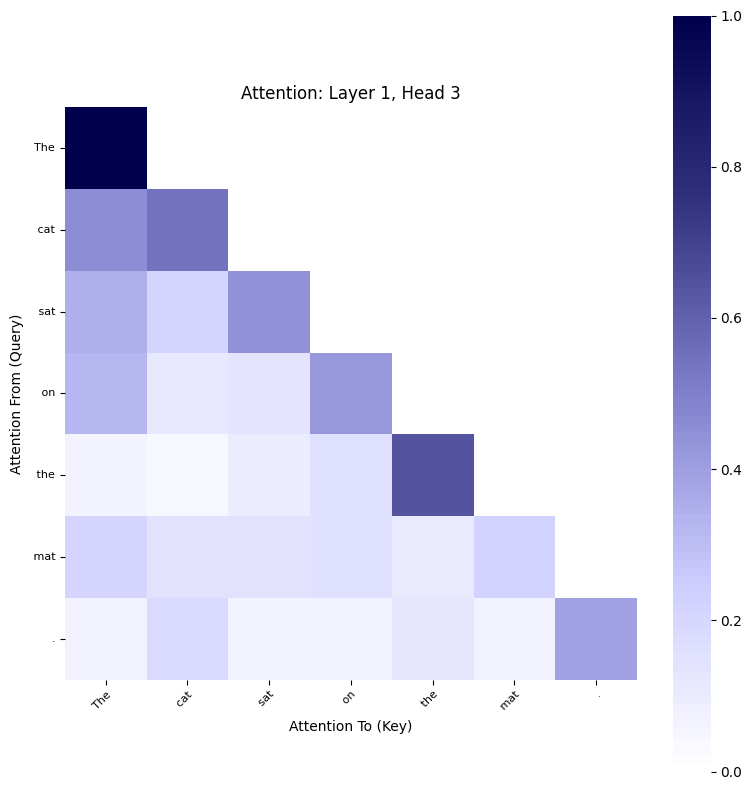

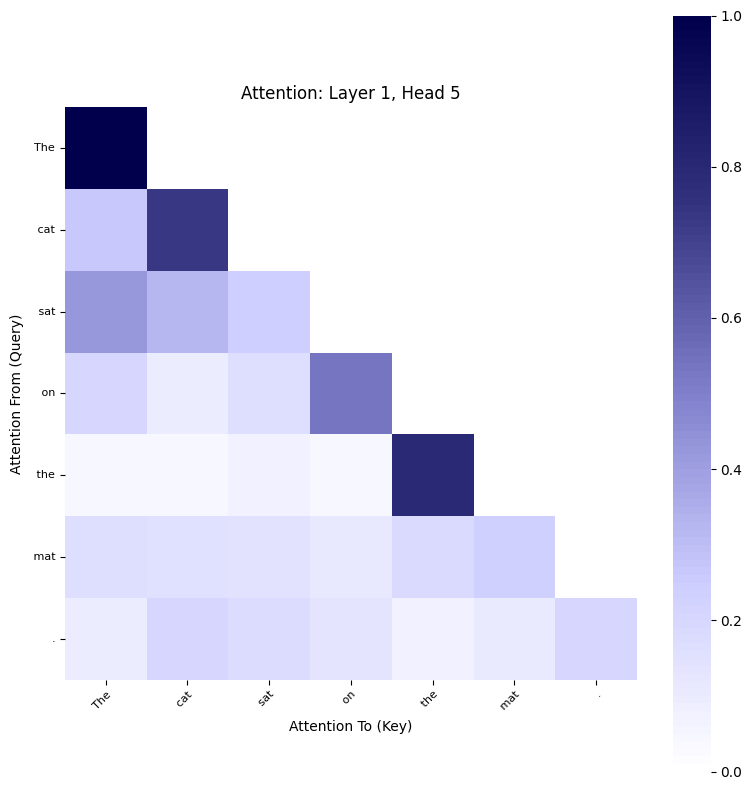

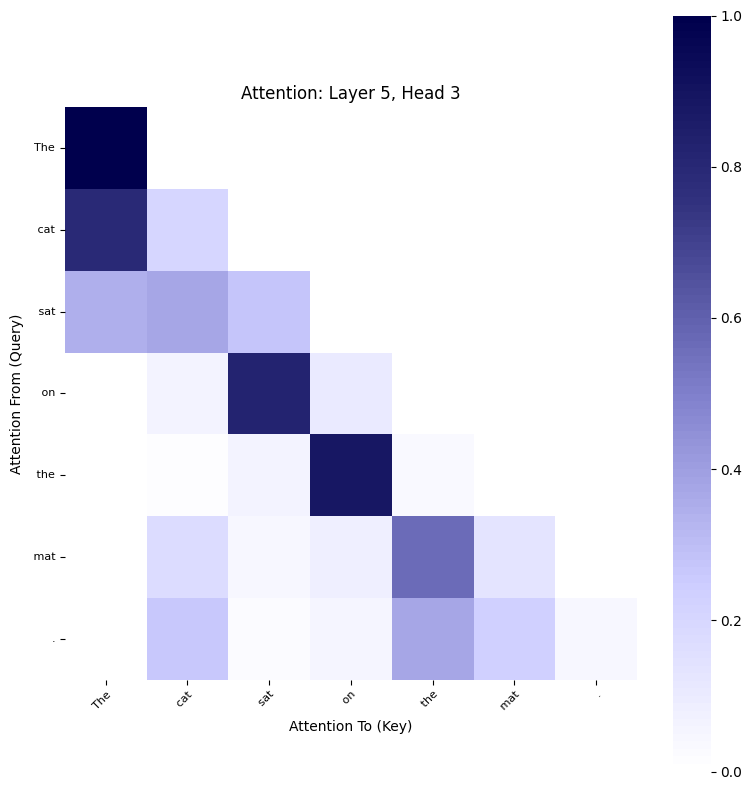

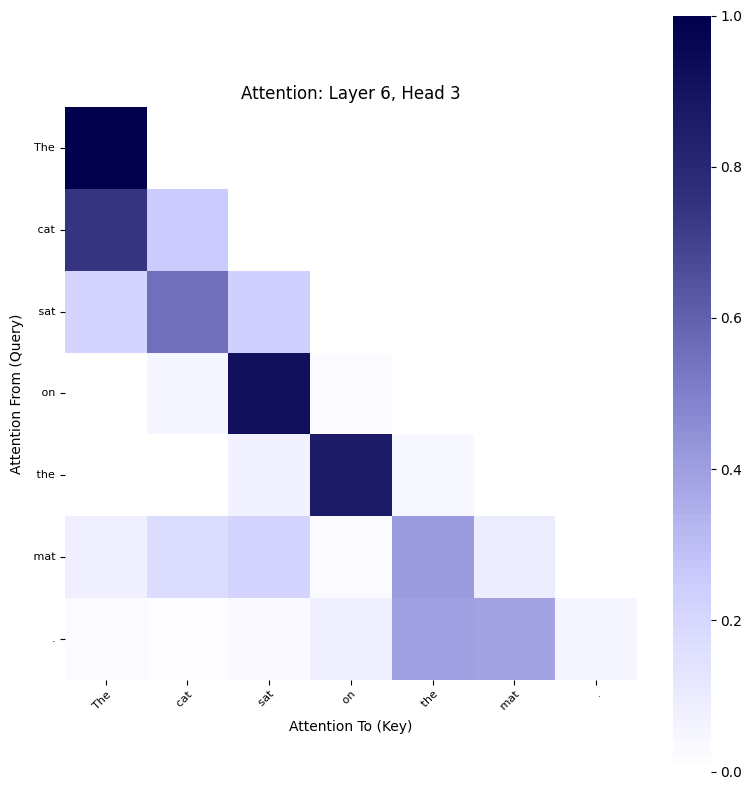

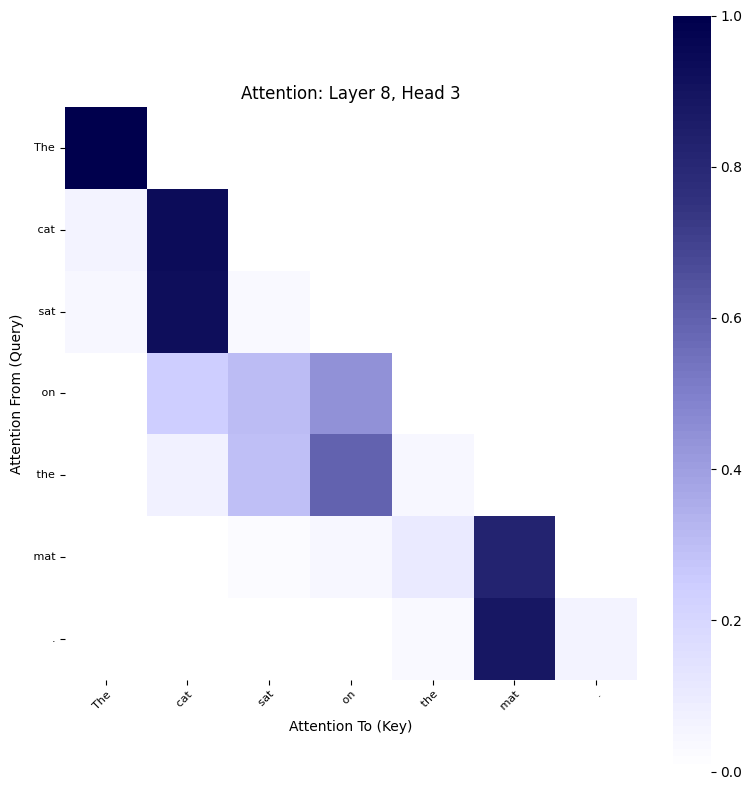

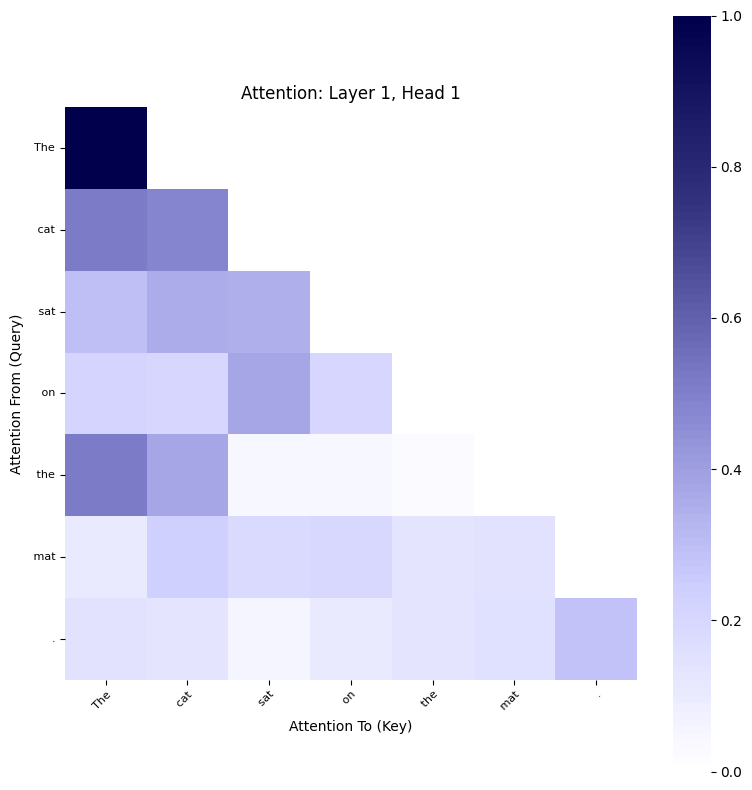

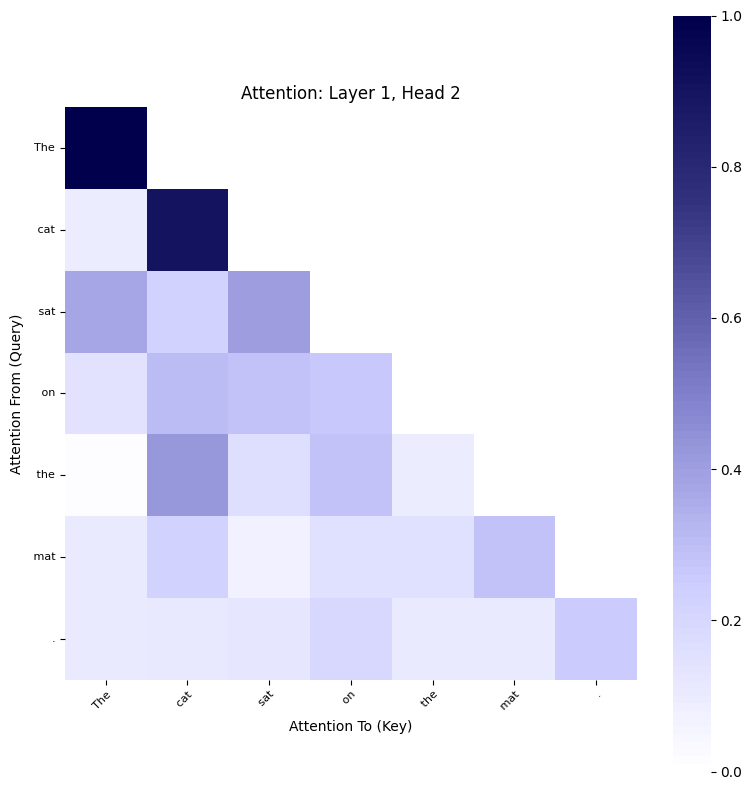

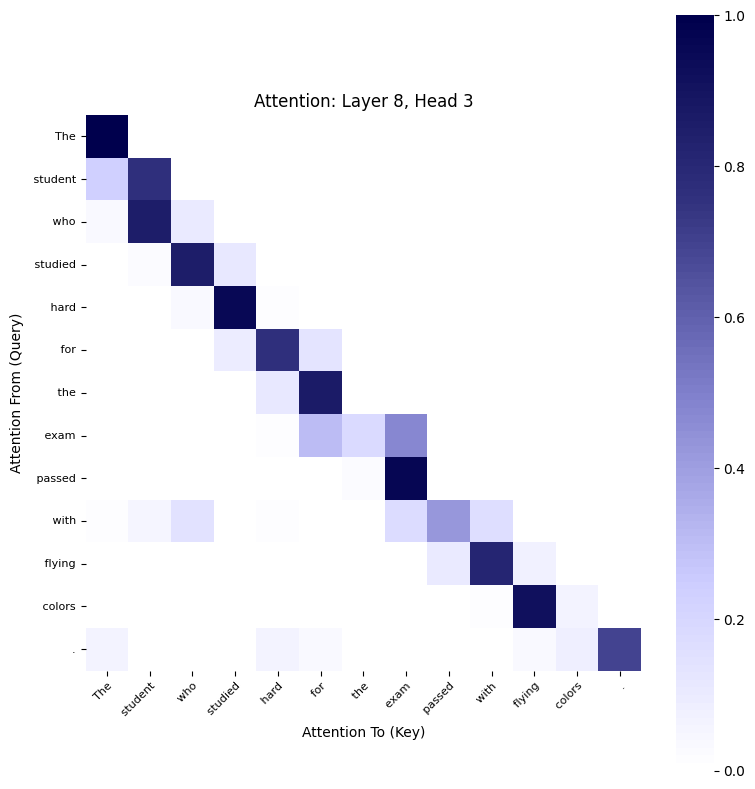

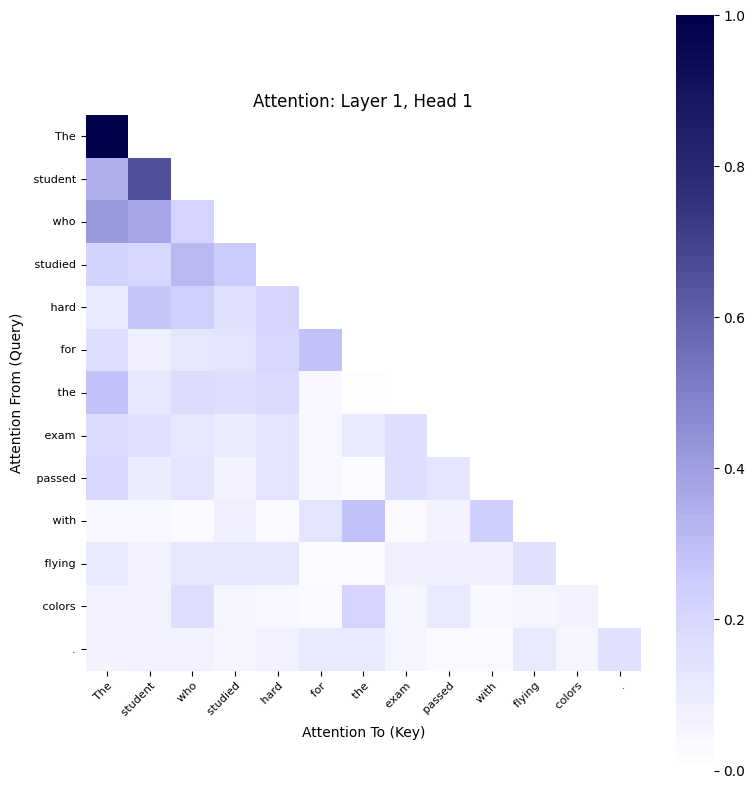

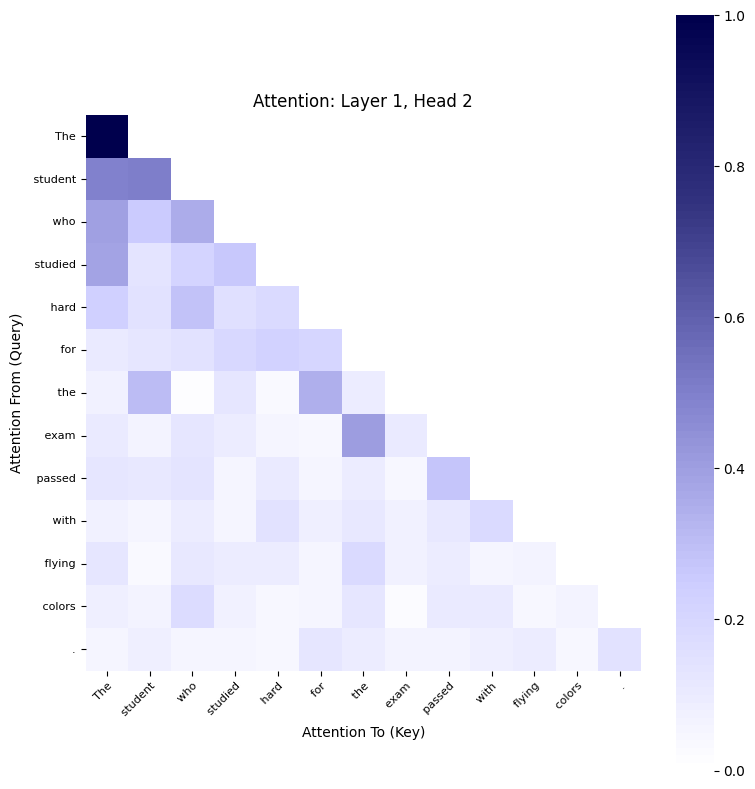

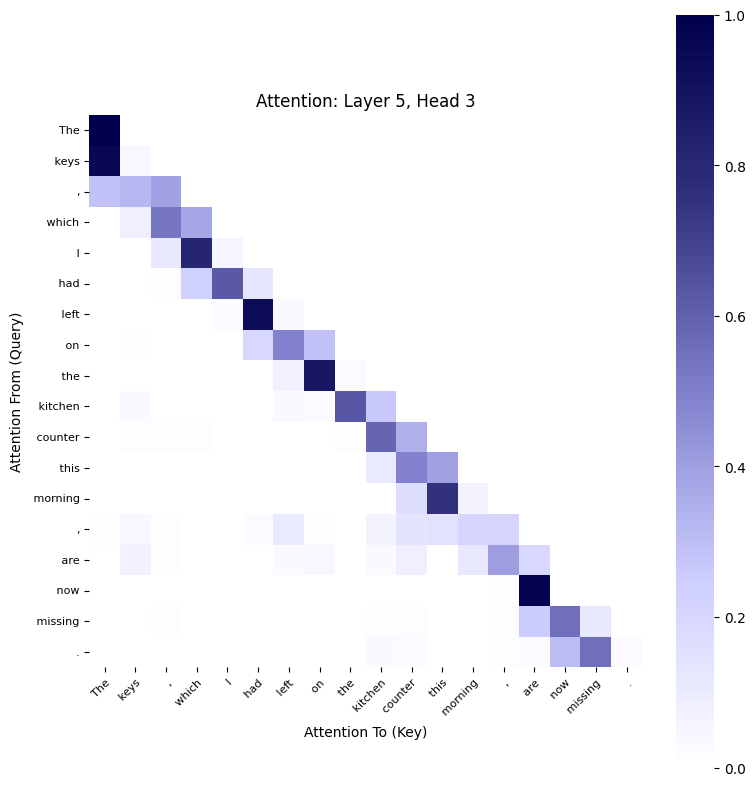

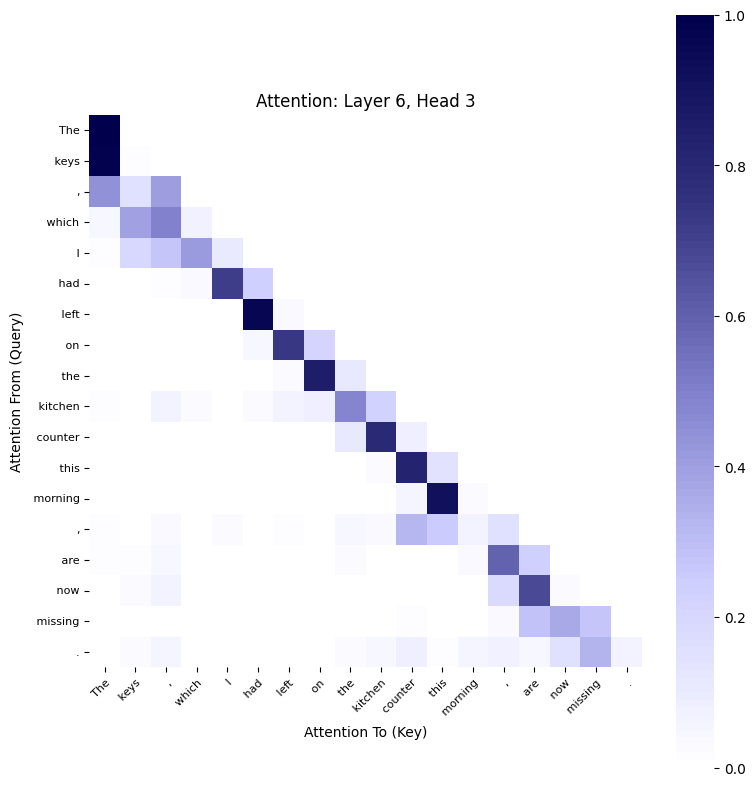

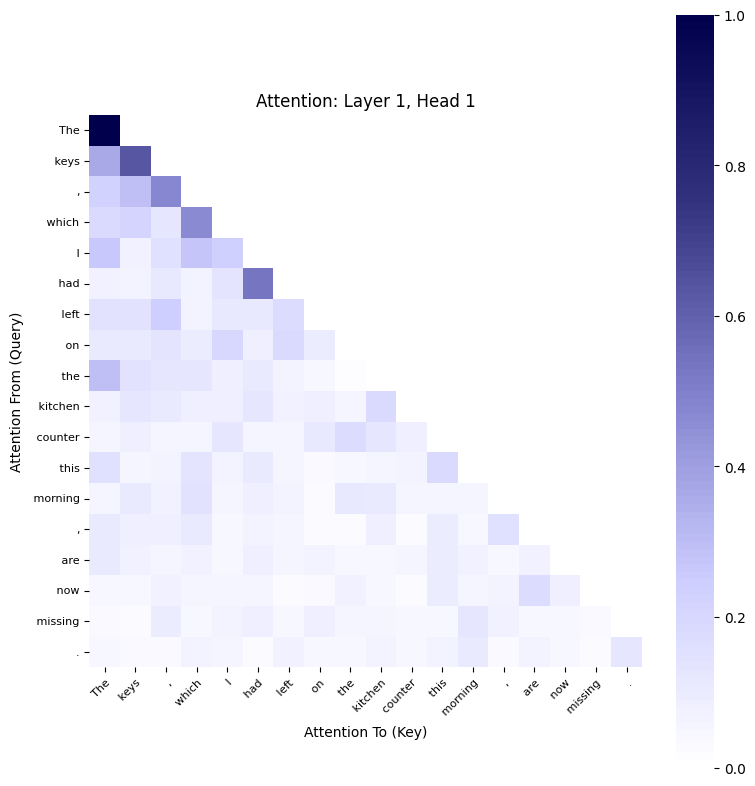

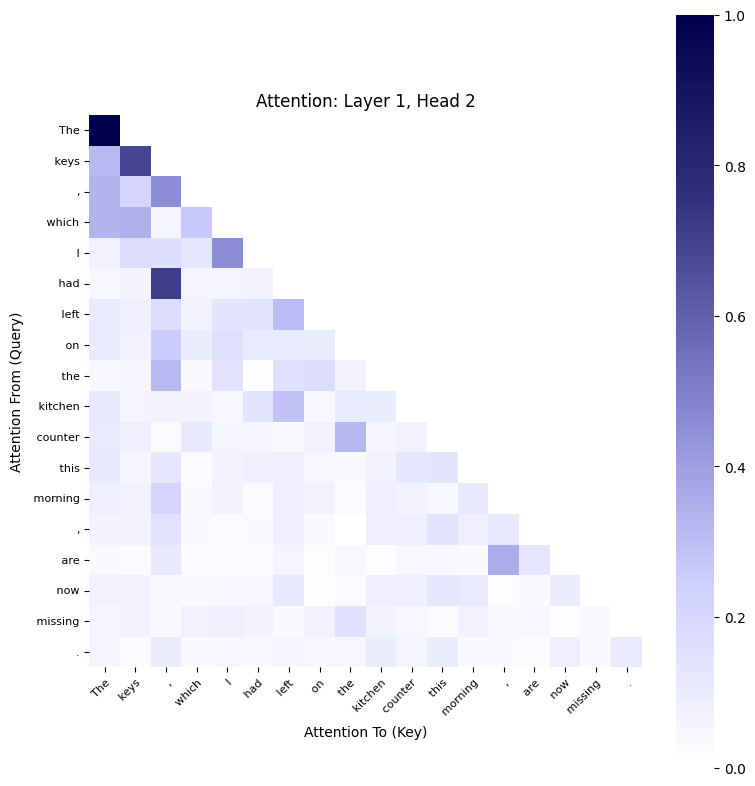

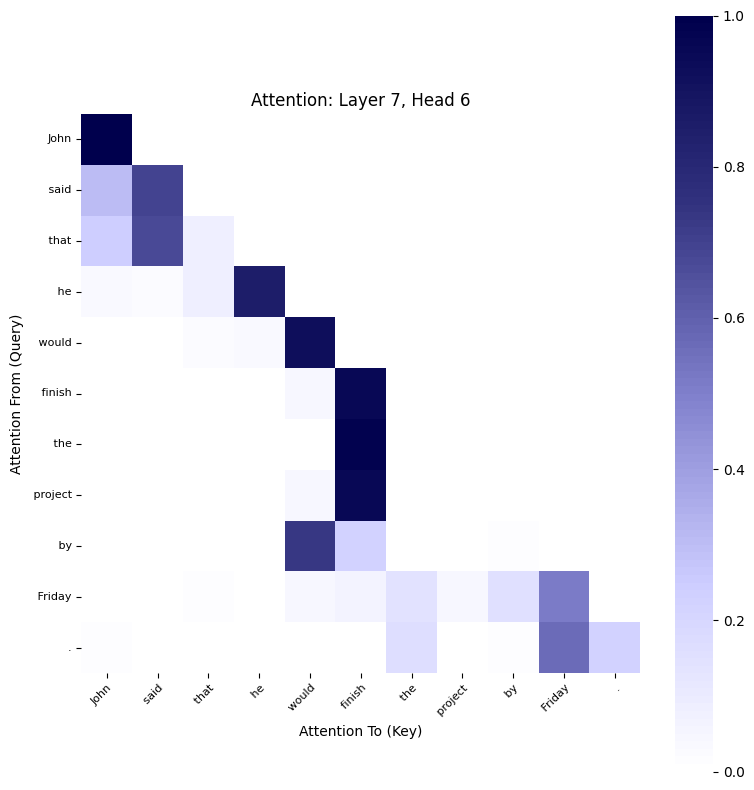

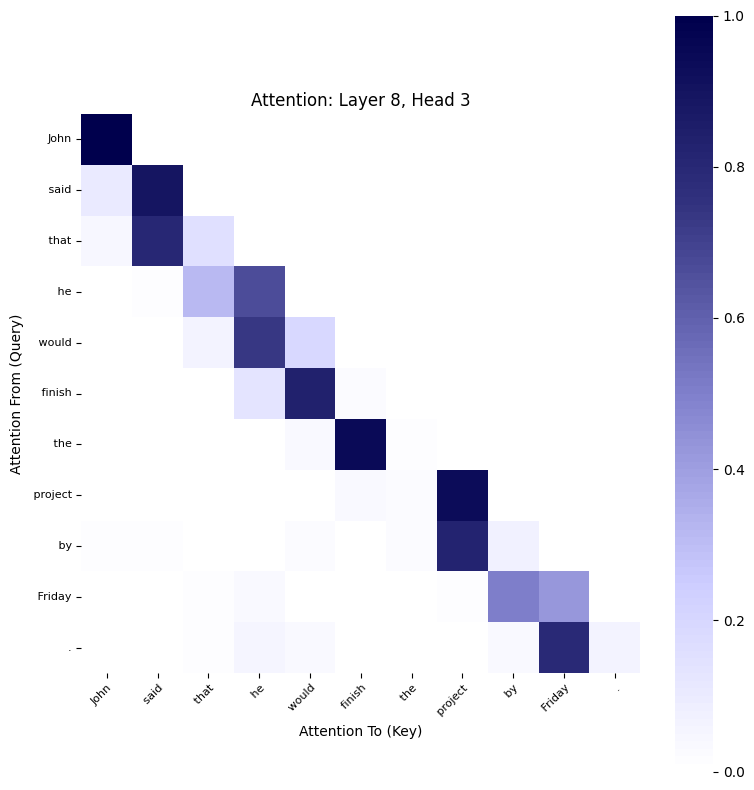

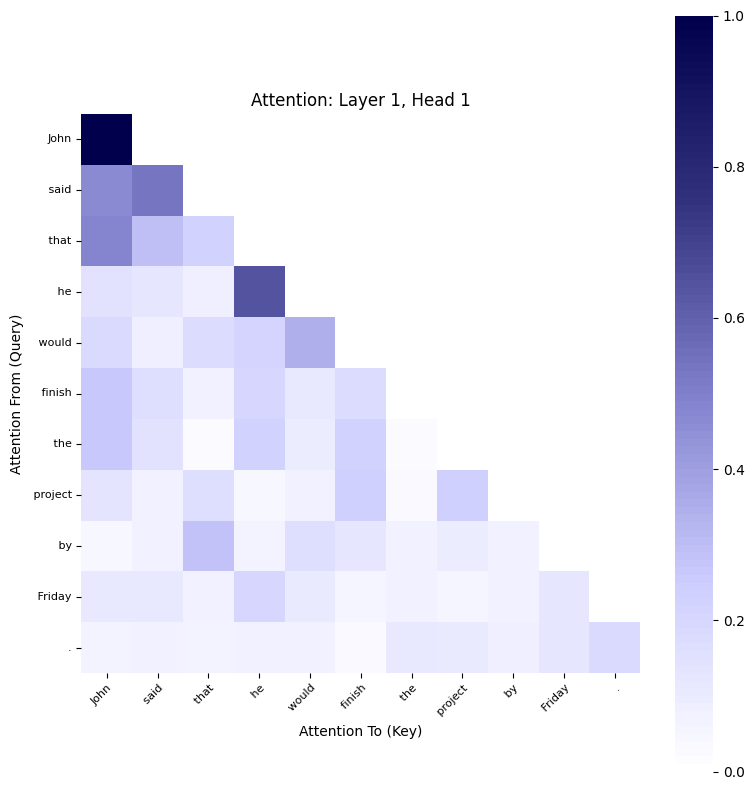

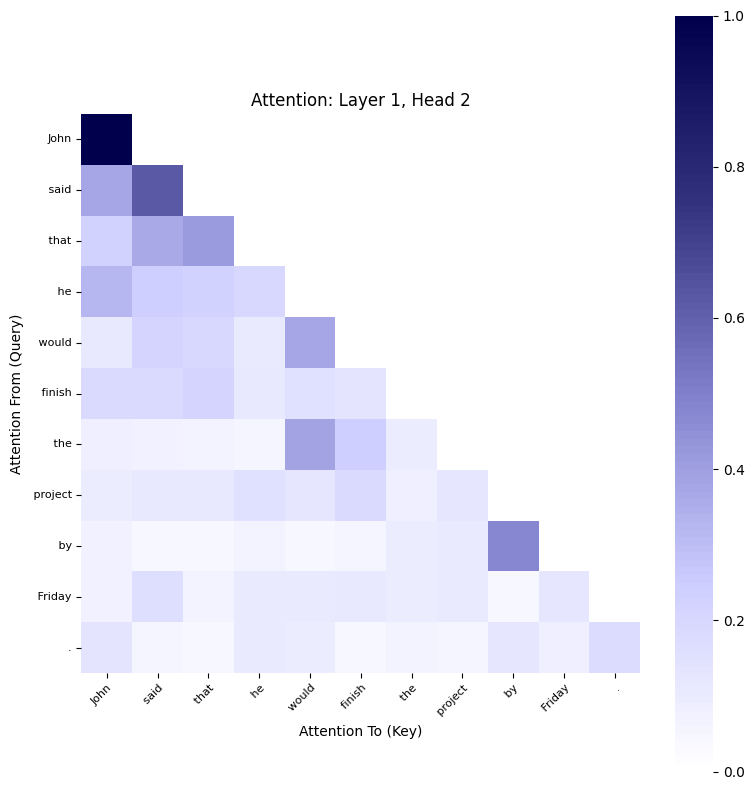

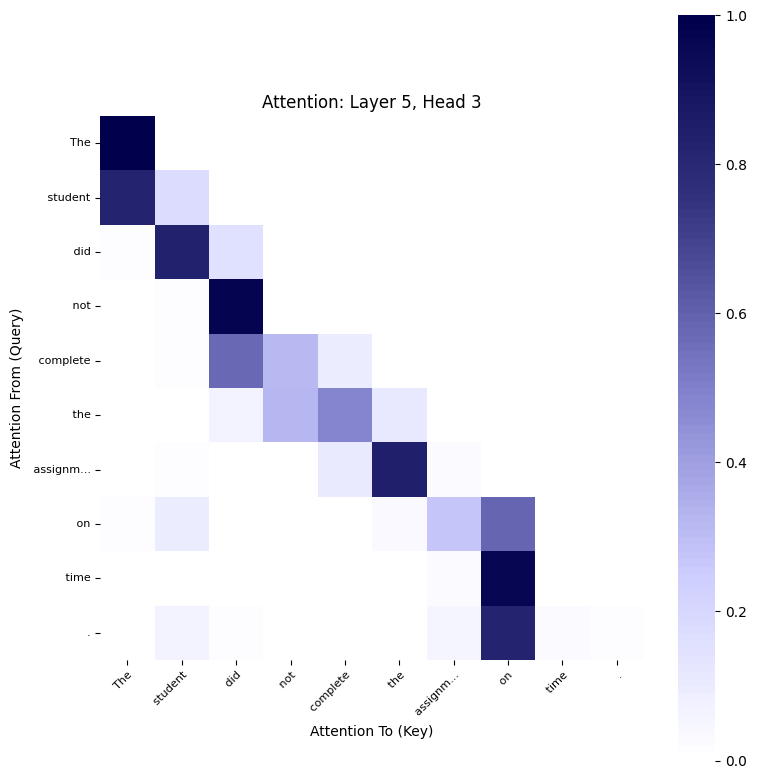

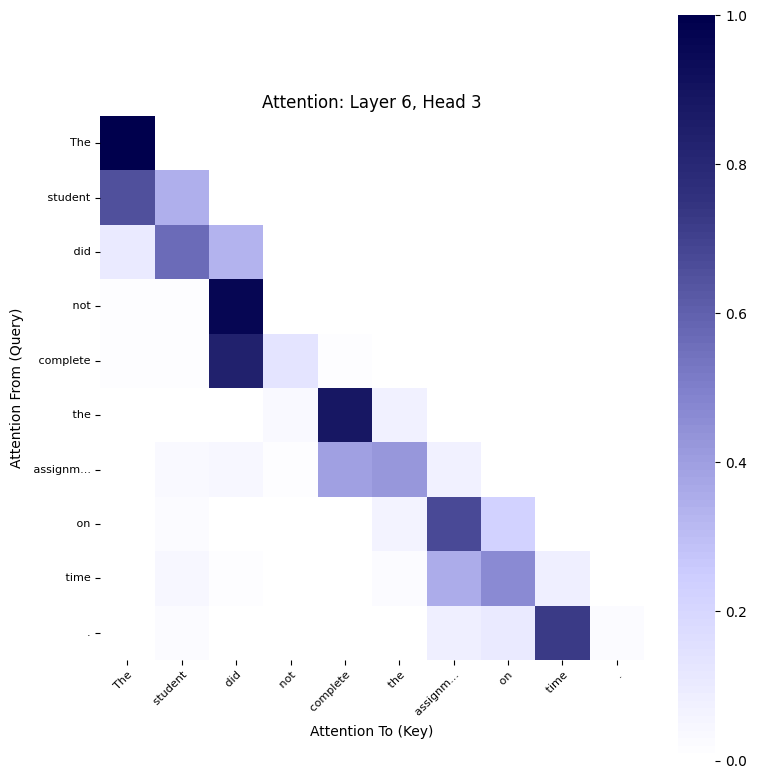

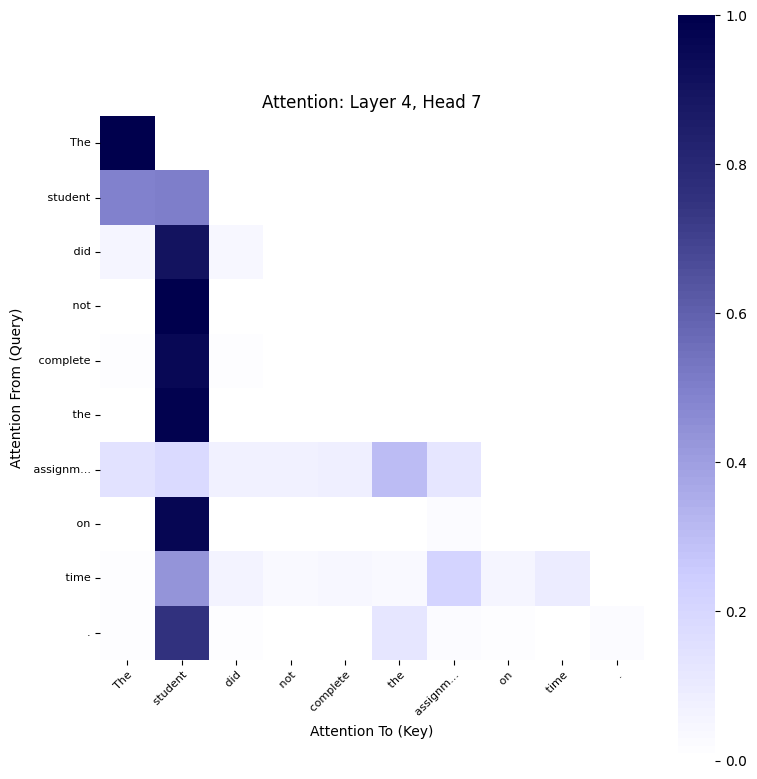

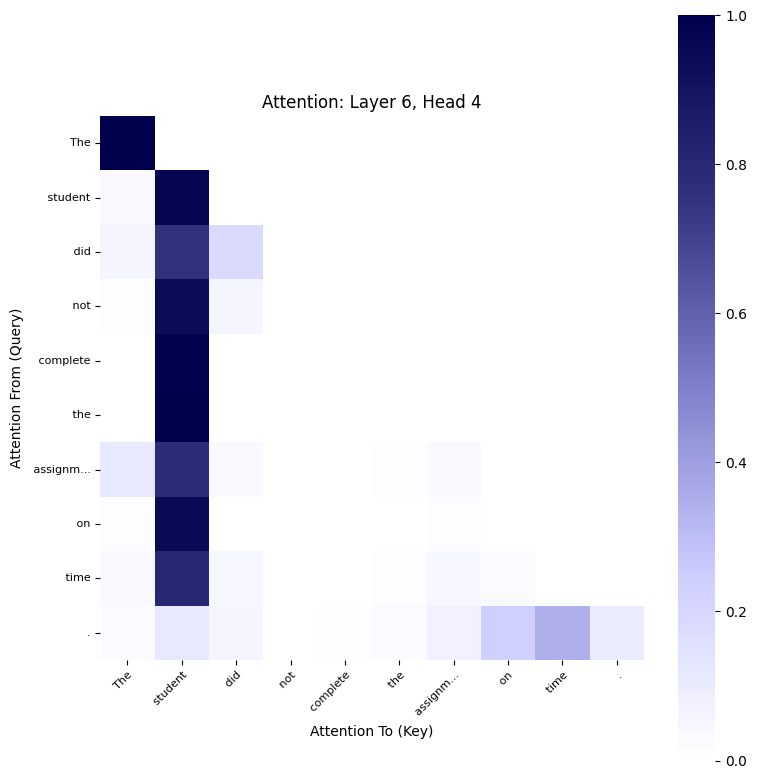

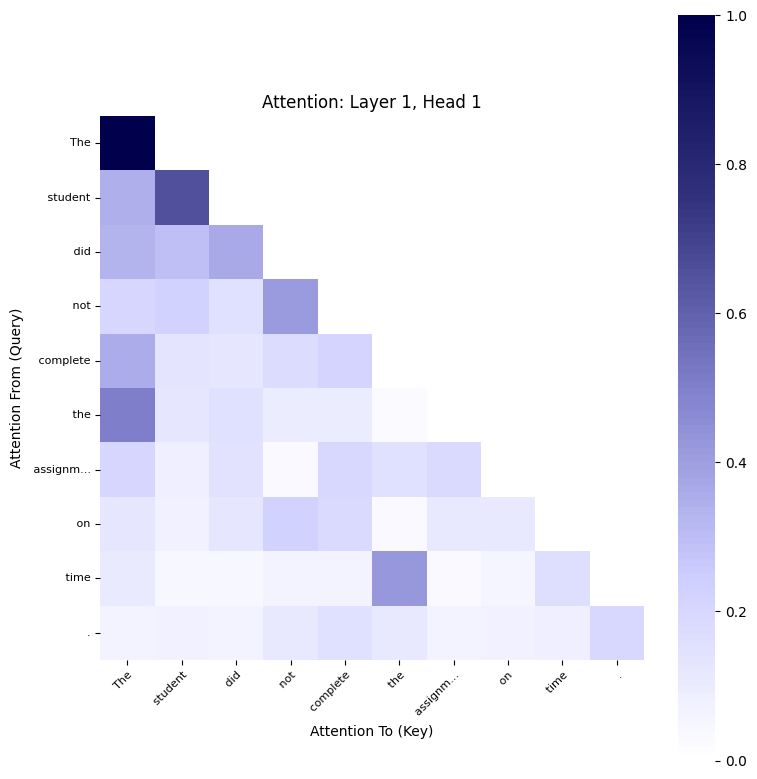

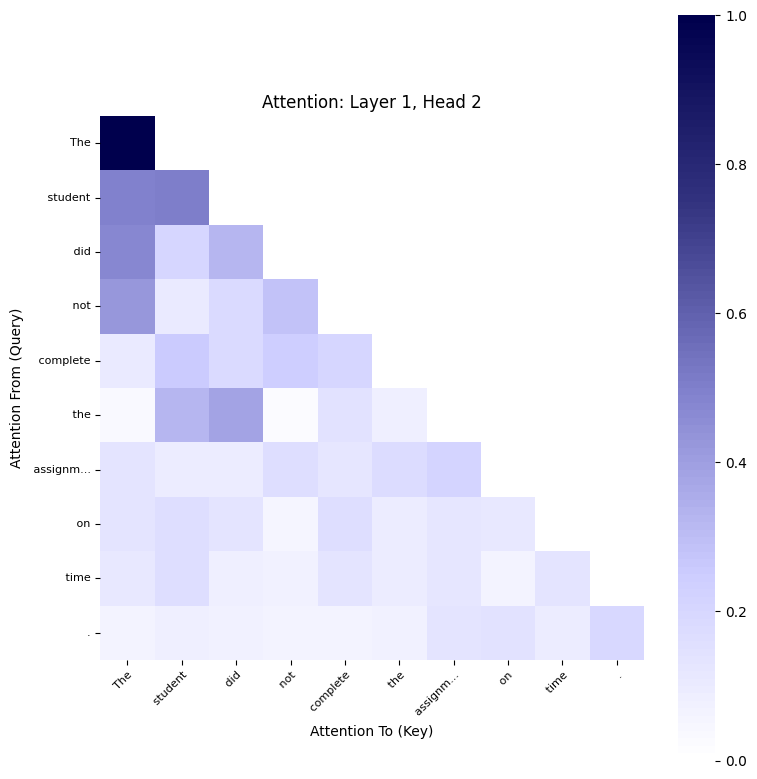

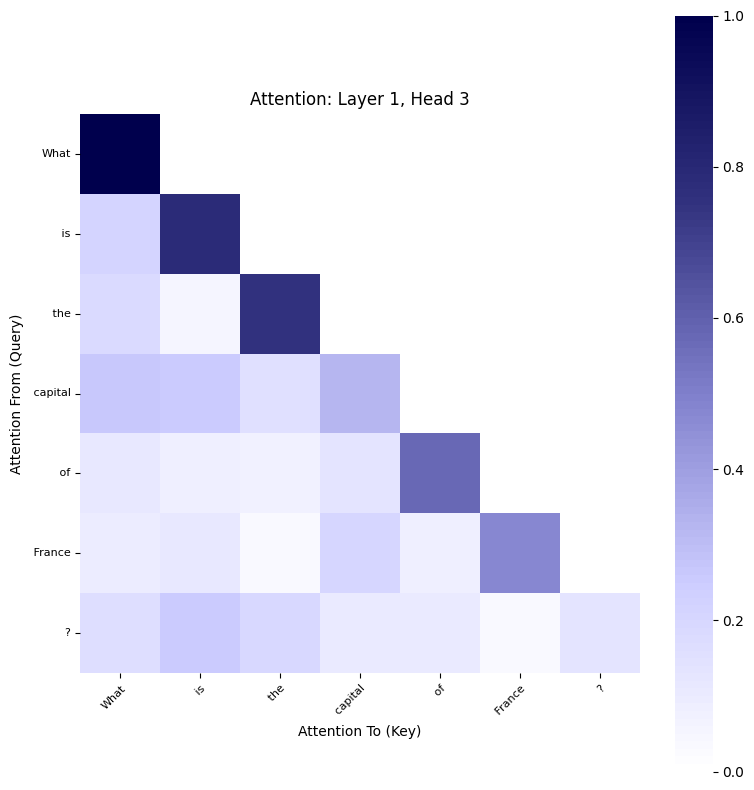

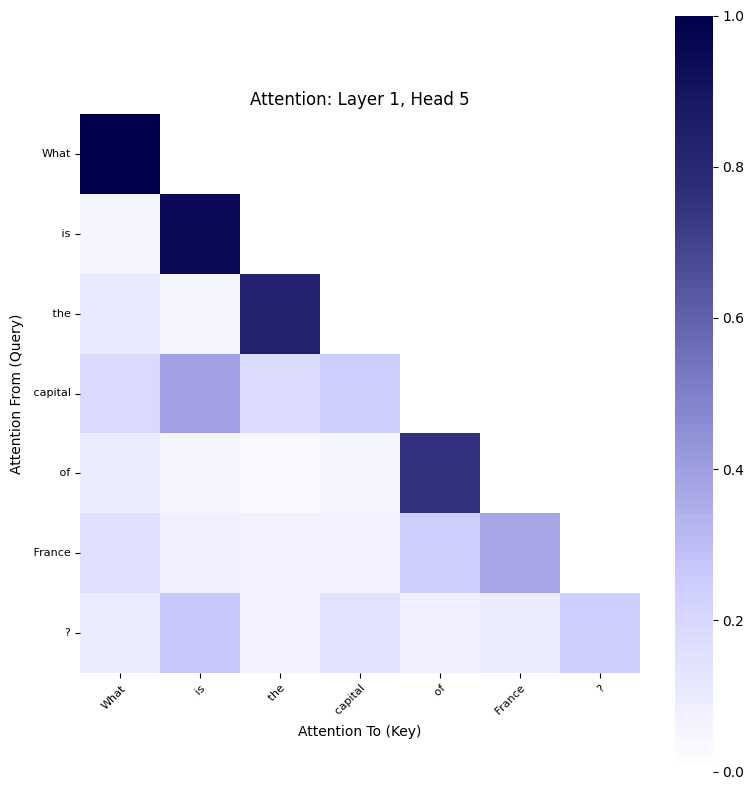

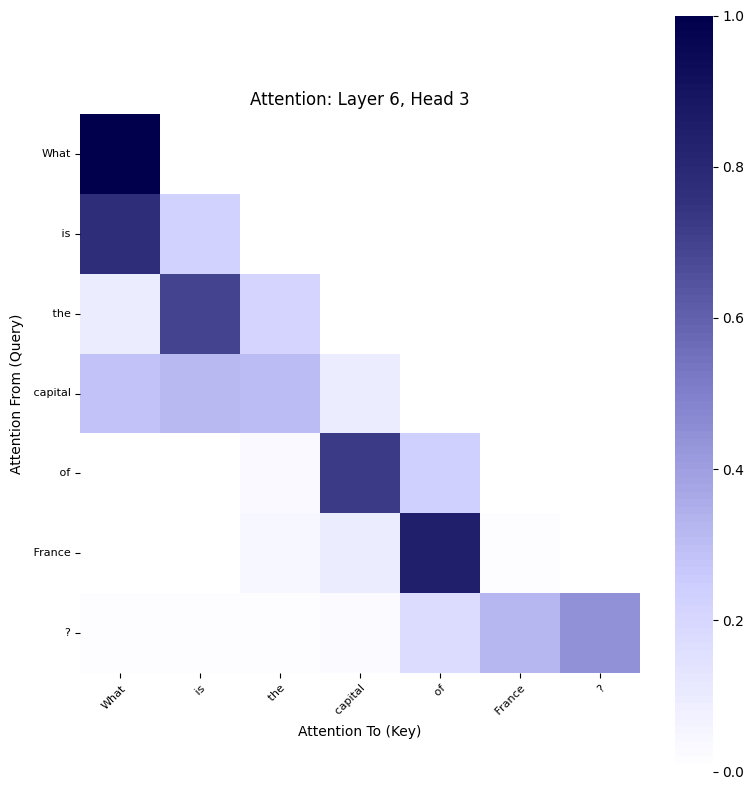

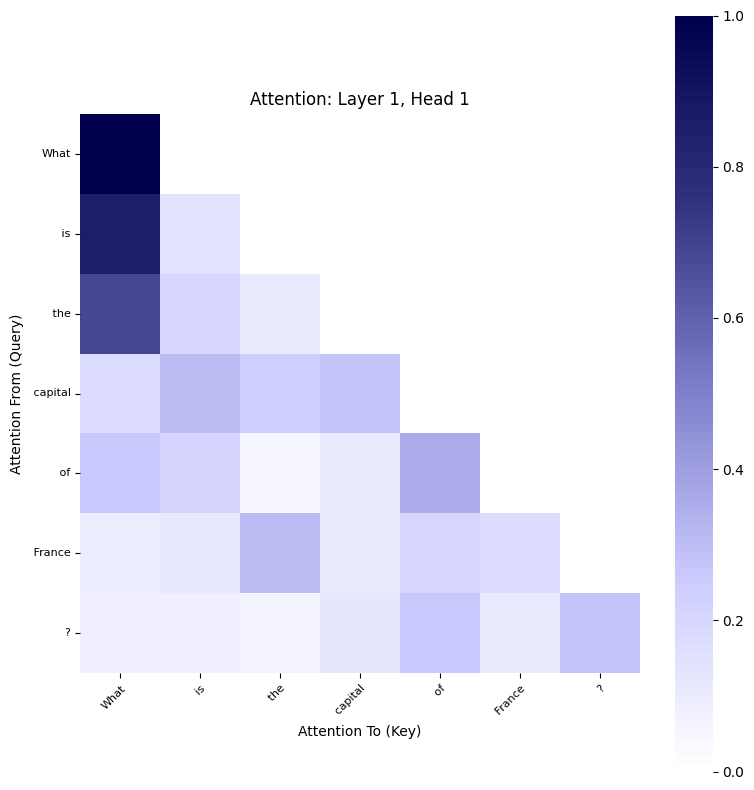

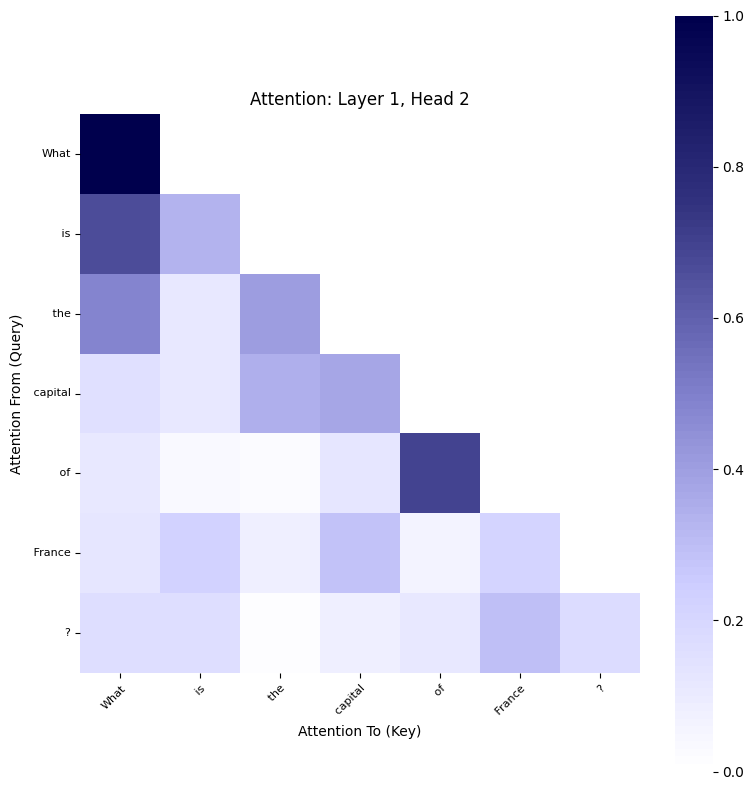

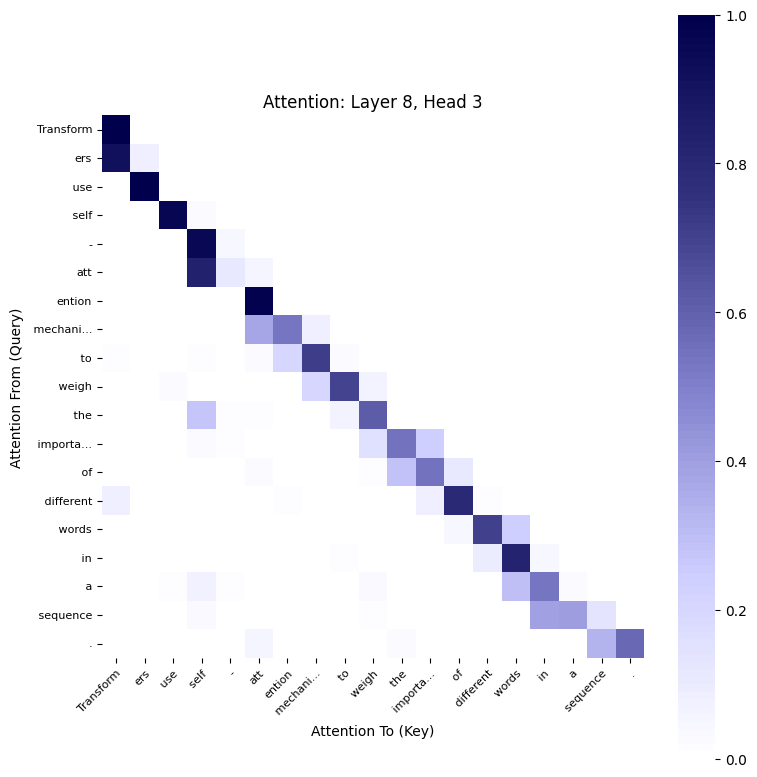

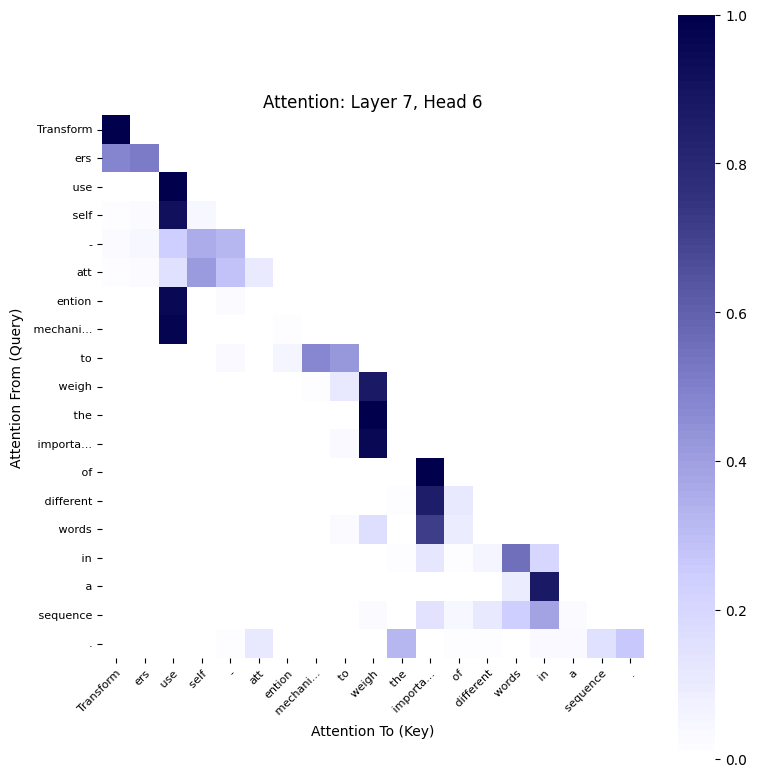

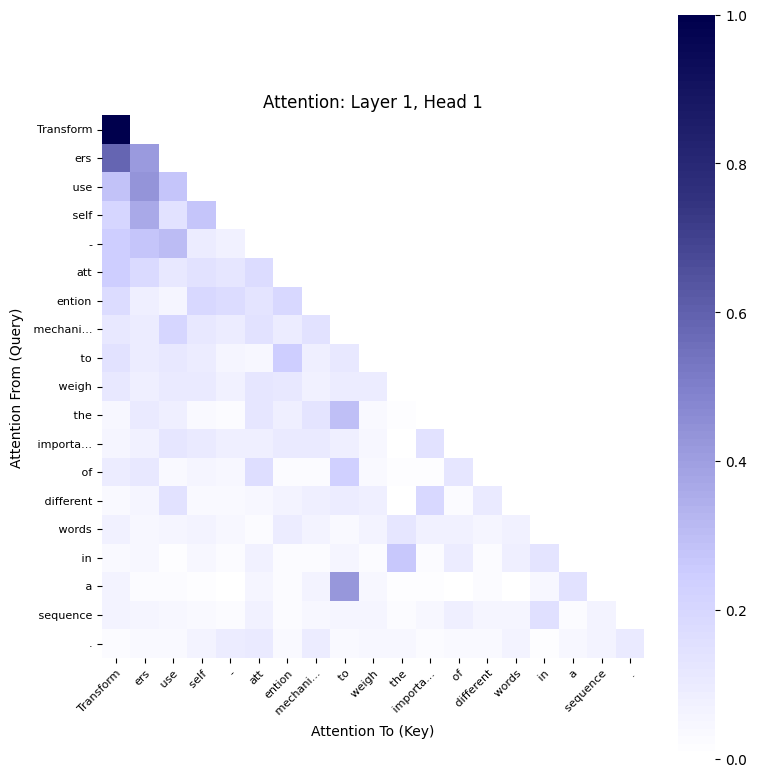

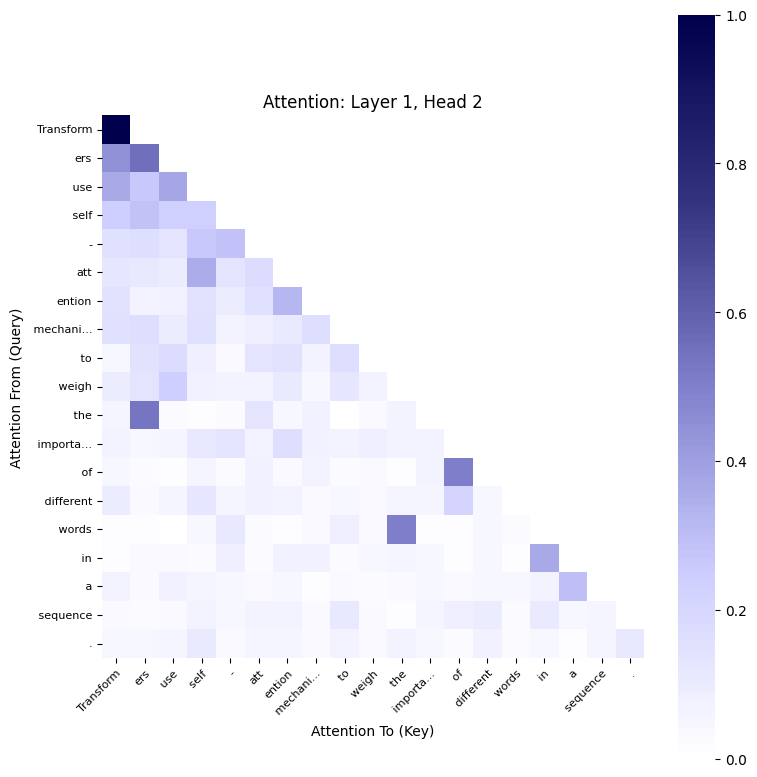

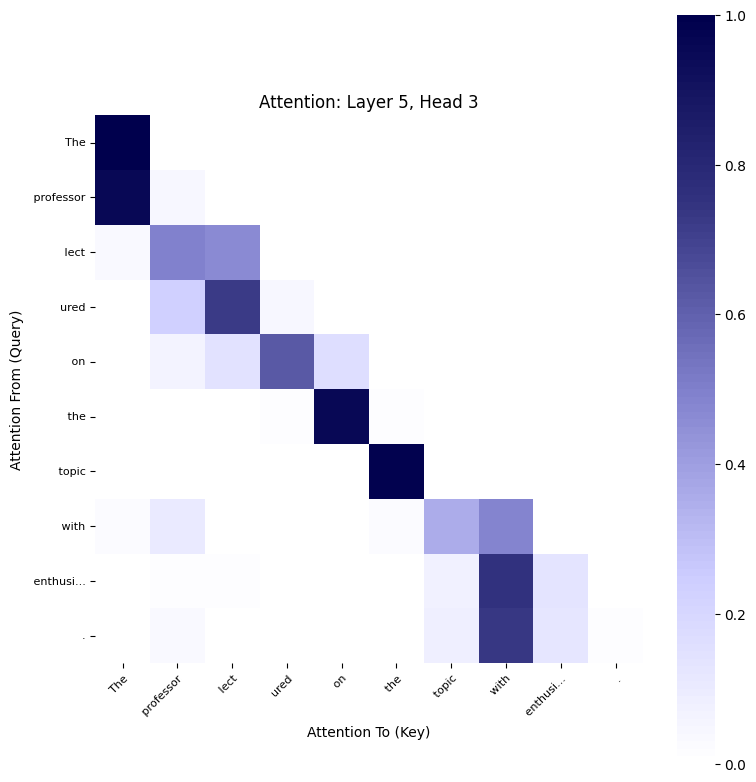

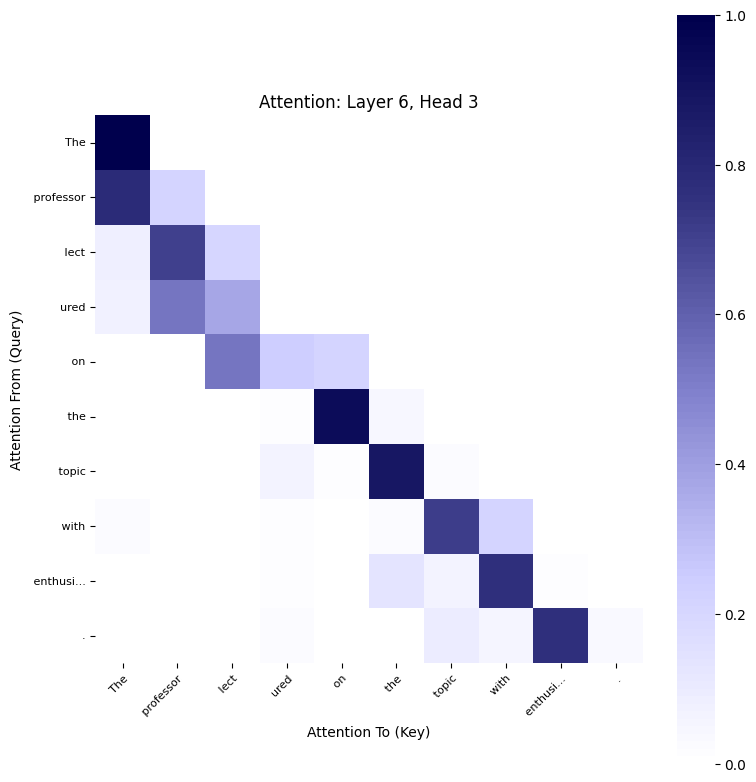

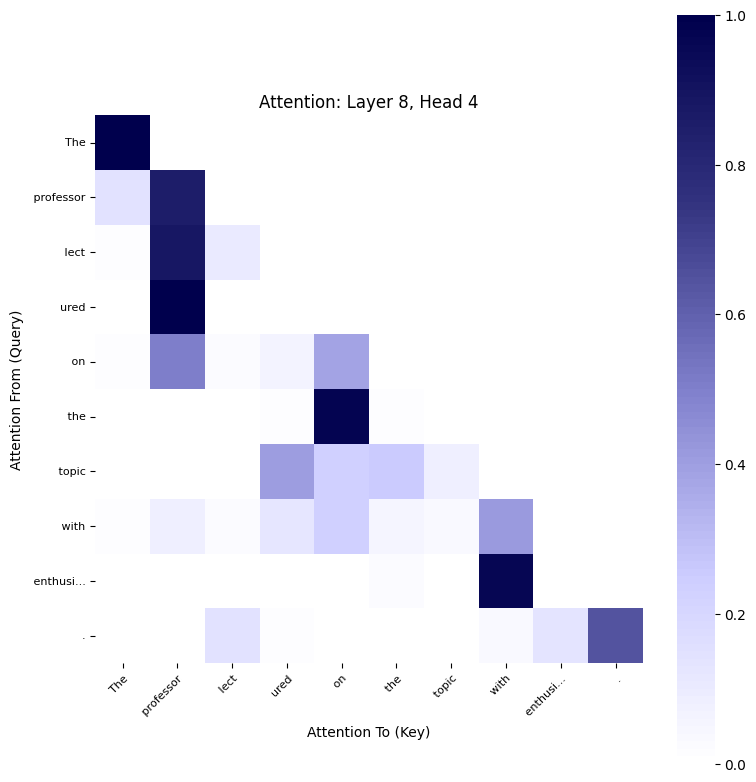

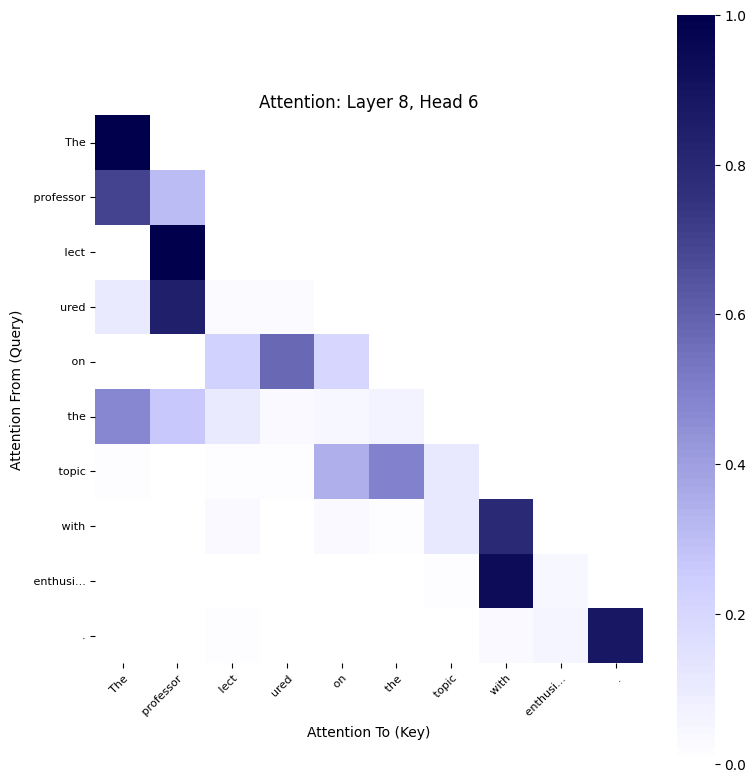

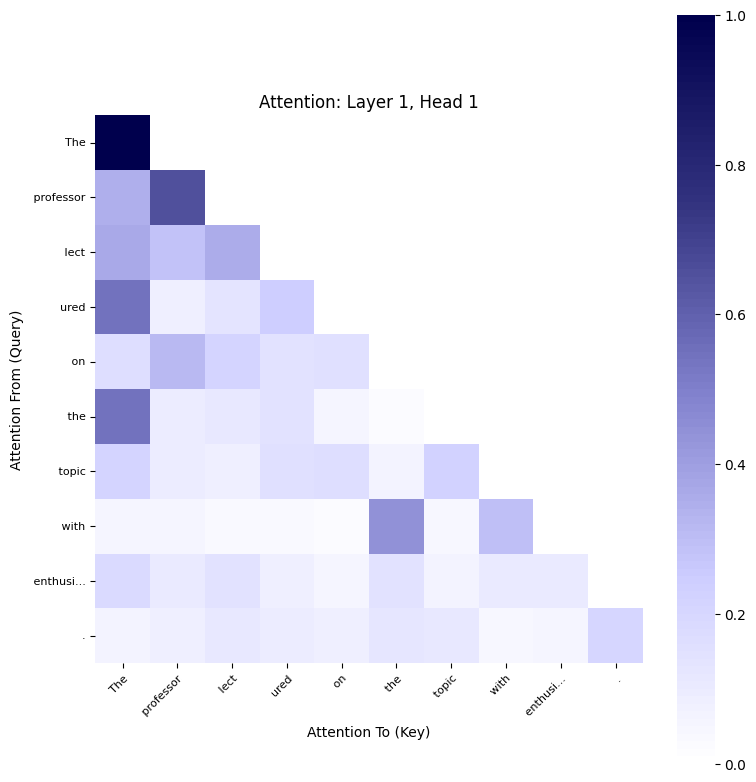

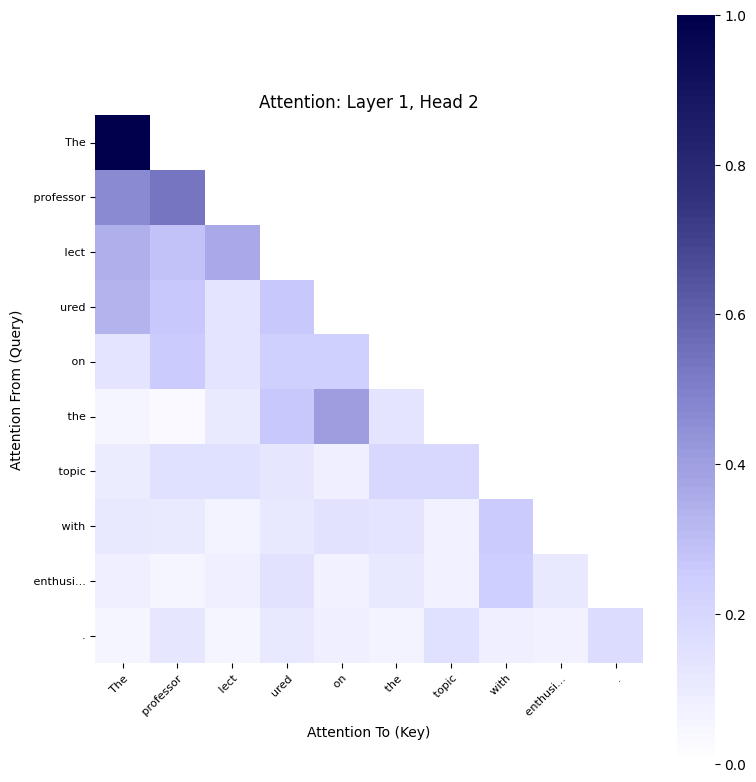

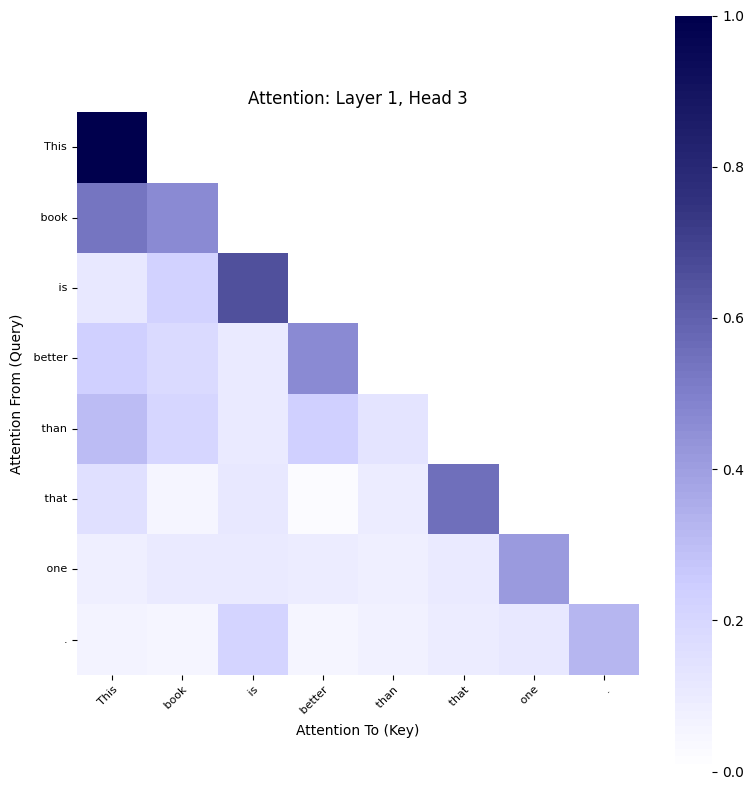

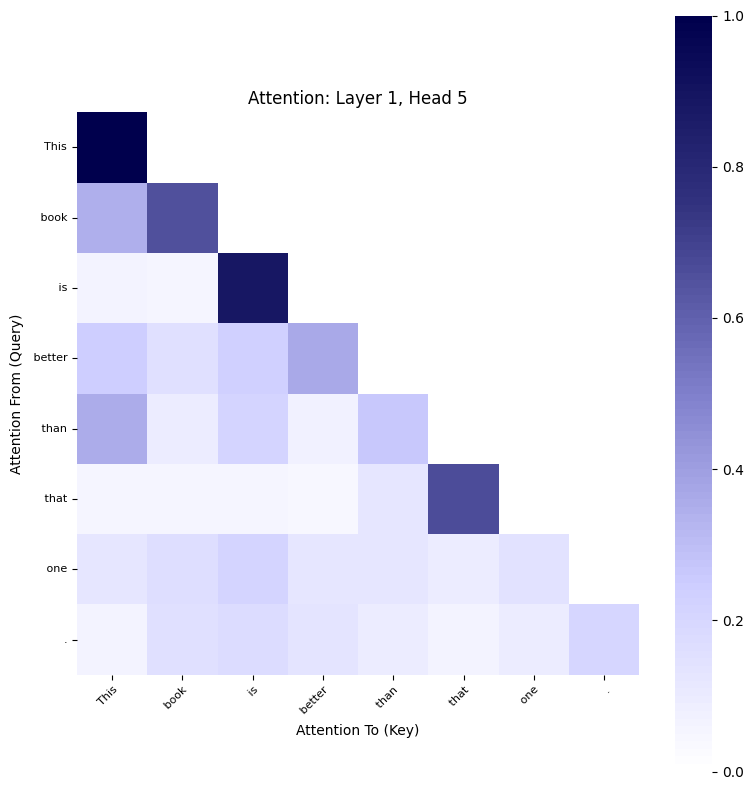

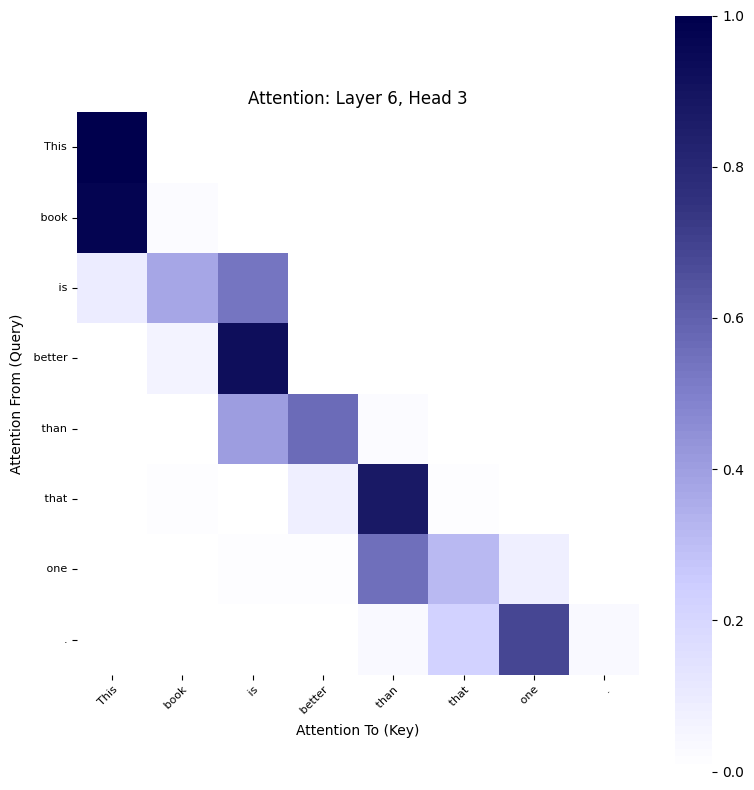

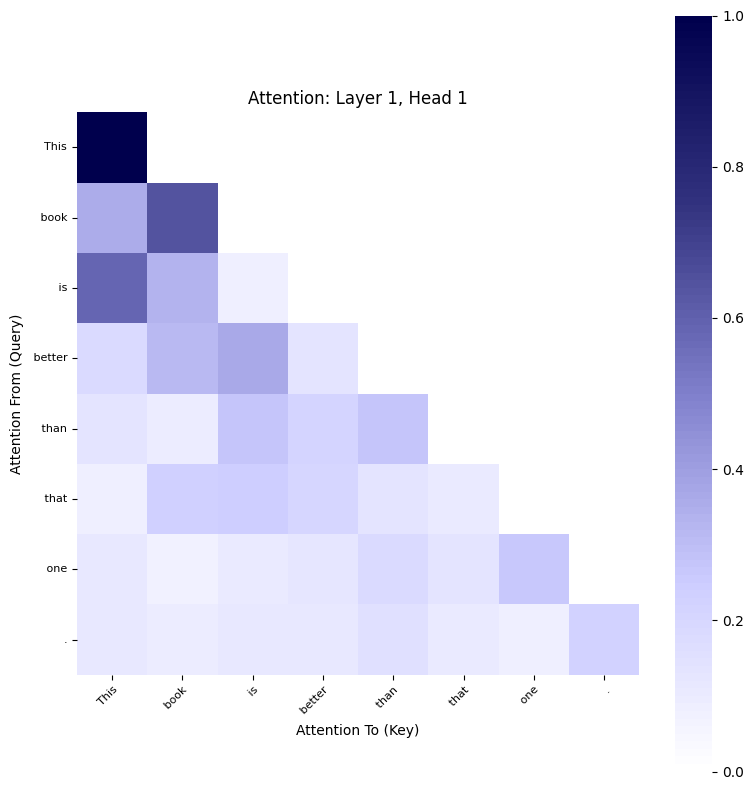

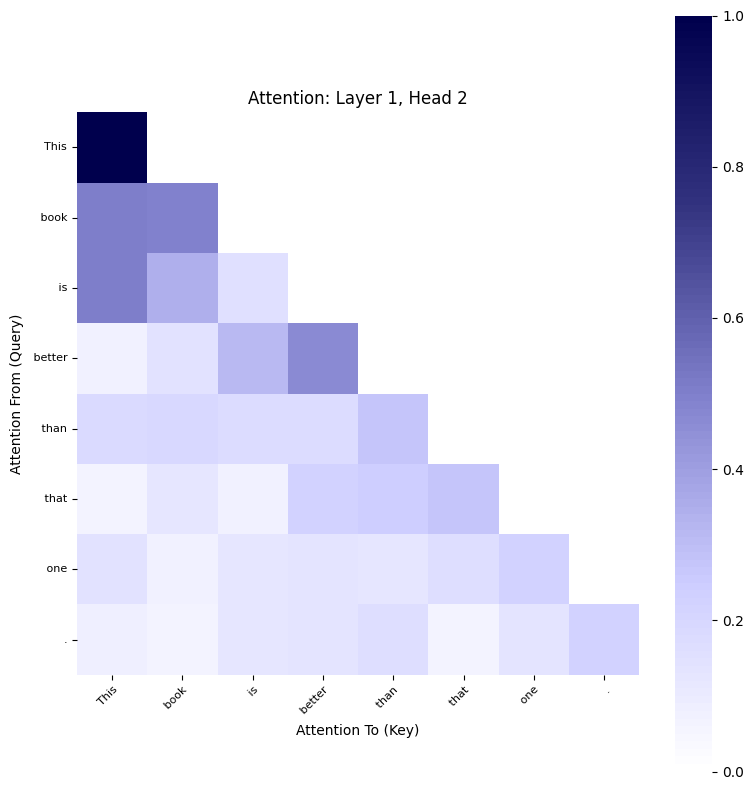

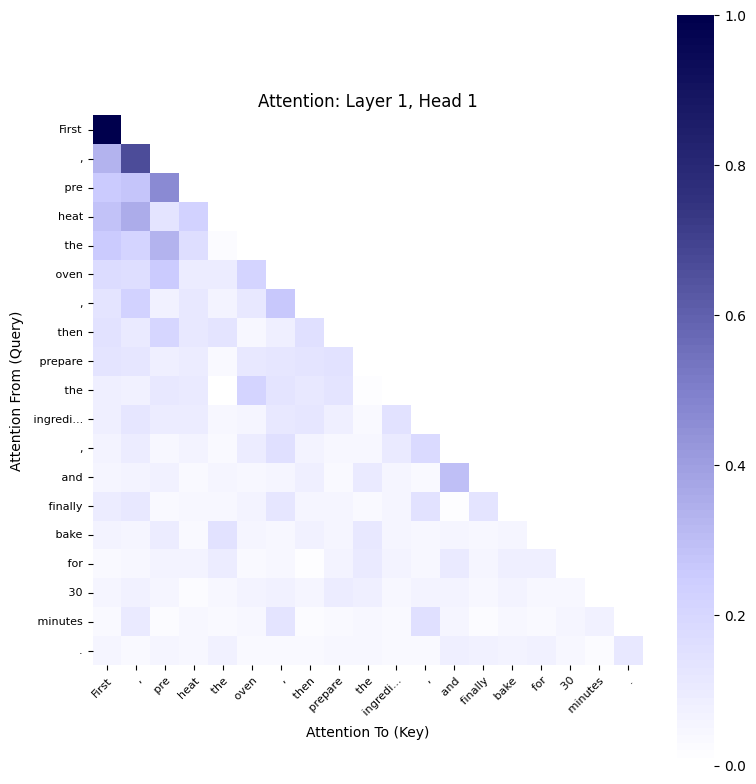

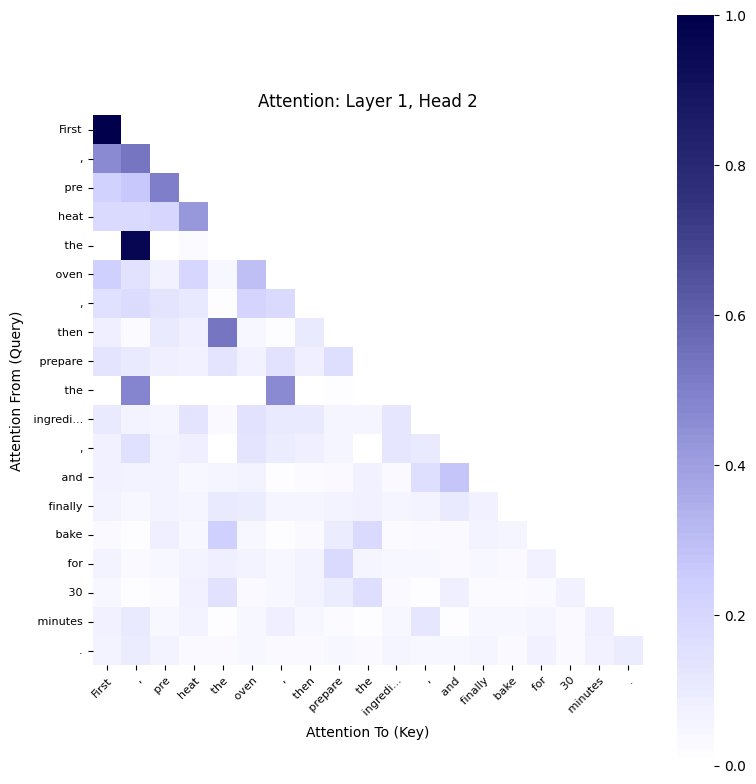

<Figure size 1400x1000 with 0 Axes>

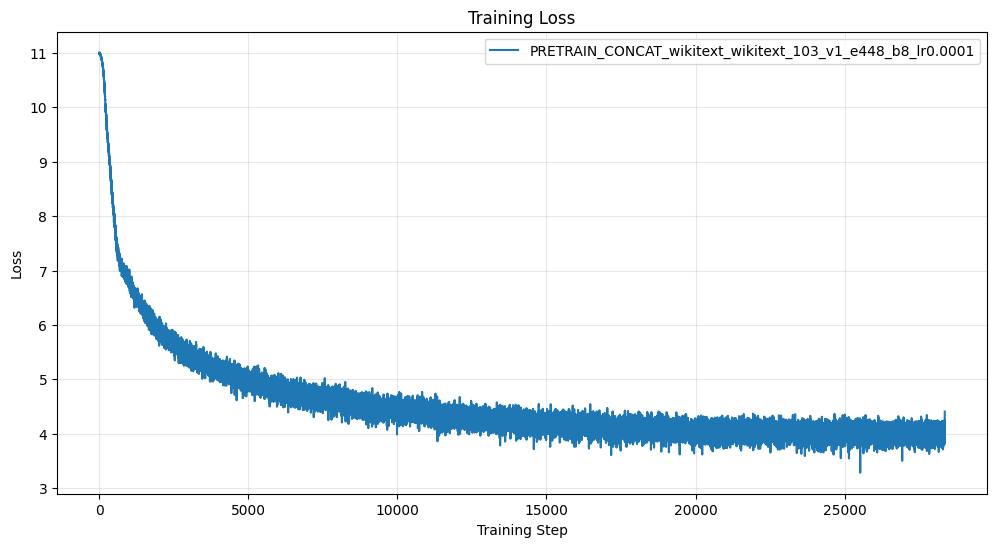

Tracker: Saved master comparison report to pico_llm_interpretability_experiments/master_comparison_report.md

IMPORTANT: Make sure all downloads have completed successfully!
If you missed any downloads, use the following code to download results:
from google.colab import files
!zip -r all_results.zip results/ pico_llm_interpretability_experiments/
files.download('all_results.zip')

PICO-LLM EXECUTION COMPLETED.


In [ ]:
# -*- coding: utf-8 -*-
"""
Pico-LLM: Transformer Interpretability Analysis

"""

# Base dependencies
import time
import random
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import os
import json
import gc  # For garbage collection
import re  # For text normalization
from tqdm.auto import tqdm  # Notebook-friendly progress bars
import pandas as pd
import seaborn as sns
from IPython.display import display, HTML  # For rich display in notebooks
from collections import defaultdict
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import MaxNLocator
import networkx as nx
from scipy.cluster.hierarchy import dendrogram, linkage
import sys

# For data loading and tokenization
try:
    from datasets import load_dataset
    import tiktoken
except ImportError:
    print("Please install required packages: pip install datasets tiktoken pandas seaborn networkx matplotlib scipy scikit-learn")
    raise

# Detect if running in Google Colab
IN_COLAB = 'google.colab' in sys.modules

# Setup downloads for Colab
if IN_COLAB:
    from google.colab import files
    print("Running in Google Colab - Auto-download functionality enabled!")

    # Try to mount Google Drive for additional backup
    try:
        from google.colab import drive
        drive.mount('/content/drive')
        DRIVE_AVAILABLE = True
        print("Google Drive mounted successfully for backup!")
    except:
        DRIVE_AVAILABLE = False
        print("Could not mount Google Drive. Will still download files to your computer.")
else:
    print("Not running in Colab - download functionality not needed.")

# --- Global instances (will be initialized in main) ---
tracker = None
global_encoder = None

# --- Results Directory ---
os.makedirs("results", exist_ok=True)

#################################################################################
# Download Helper Functions for Colab
#################################################################################

def auto_download_results(result_dir, prefix="pico_llm"):
    """
    Compress and download results directory to local machine
    For use in Google Colab
    """
    if not IN_COLAB:
        print("Not running in Colab - download function not needed")
        return False

    try:
        timestamp = time.strftime("%Y%m%d_%H%M%S")
        zip_filename = f"{prefix}_{timestamp}.zip"

        print(f"\n{'='*80}")
        print(f"COMPRESSING RESULTS FOR DOWNLOAD: {zip_filename}")
        print(f"{'='*80}")

        # Compress results
        !zip -r {zip_filename} {result_dir}

        # Download to local machine
        files.download(zip_filename)

        print(f"\nDownload initiated for {zip_filename}")
        print("If the download dialog doesn't appear, check your browser's download settings")
        print("or look for the file in your downloads folder.")

        # Backup to Google Drive if available
        if DRIVE_AVAILABLE:
            drive_backup_dir = "/content/drive/MyDrive/pico_llm_backups"
            os.makedirs(drive_backup_dir, exist_ok=True)
            drive_path = f"{drive_backup_dir}/{zip_filename}"
            !cp {zip_filename} {drive_path}
            print(f"\nBackup also saved to Google Drive: {drive_path}")

        return True
    except Exception as e:
        print(f"Error during download: {e}")
        print("You can manually download your results by running:")
        print(f"!zip -r {prefix}_{timestamp}.zip {result_dir}")
        print("from google.colab import files")
        print(f"files.download('{prefix}_{timestamp}.zip')")
        return False

#################################################################################
# PART 1: Test Sentences for Attention Analysis
#################################################################################

# Test sentences designed to probe different linguistic phenomena
SIMPLE_SENTENCES = [
    "The cat sat on the mat.",
    "The dog chased the ball across the yard.",
    "She opened the door and walked into the room."
]

SYNTAX_COMPLEX = [
    "The student who studied hard for the exam passed with flying colors.",
    "Although it was raining, they decided to go for a walk in the park.",
    "If the company increases its profits, the shareholders will receive larger dividends."
]

LONG_RANGE_DEPENDENCIES = [
    "The keys, which I had left on the kitchen counter this morning, are now missing.",
    "The CEO, despite objections from the board of directors, implemented the new policy.",
    "The book that my professor recommended last semester is finally available in the library."
]

COREFERENCE_EXAMPLES = [
    "John said that he would finish the project by Friday.",
    "After Mary graduated, she moved to New York to start her new job.",
    "The engineers examined the bridge, and they determined it was unsafe."
]

NEGATION_EXAMPLES = [
    "The student did not complete the assignment on time.",
    "No one believed that he could climb the mountain.",
    "She hasn't visited Paris, but she plans to go next summer."
]

QUESTIONS = [
    "What is the capital of France?",
    "How do neural networks learn from data?",
    "Why did the company's stock price fall yesterday?"
]

TECHNICAL_CONTENT = [
    "Transformers use self-attention mechanisms to weigh the importance of different words in a sequence.",
    "The gradient descent algorithm minimizes the loss function by iteratively updating the model parameters.",
    "In computer vision, convolutional neural networks extract hierarchical features from input images."
]

AMBIGUOUS_SENTENCES = [
    "The professor lectured on the topic with enthusiasm.",  # Who has enthusiasm?
    "They saw the mountains flying over the clouds.",  # Who's flying?
    "The police arrested the protesters because they were violent."  # Who was violent?
]

COMPARATIVE_SENTENCES = [
    "This book is better than that one.",
    "Programming in Python is easier than programming in C++.",
    "The new model performs more efficiently than the older version."
]

TEMPORAL_SEQUENCES = [
    "First, preheat the oven, then prepare the ingredients, and finally bake for 30 minutes.",
    "She woke up, brushed her teeth, took a shower, and then had breakfast.",
    "Before signing the contract, make sure to read all the terms and conditions carefully."
]

ALL_TEST_CATEGORIES = {
    "Simple Sentences": SIMPLE_SENTENCES,
    "Complex Syntax": SYNTAX_COMPLEX,
    "Long-Range Dependencies": LONG_RANGE_DEPENDENCIES,
    "Coreference Resolution": COREFERENCE_EXAMPLES,
    "Negation": NEGATION_EXAMPLES,
    "Questions": QUESTIONS,
    "Technical Content": TECHNICAL_CONTENT,
    "Ambiguous Sentences": AMBIGUOUS_SENTENCES,
    "Comparisons": COMPARATIVE_SENTENCES,
    "Temporal Sequences": TEMPORAL_SEQUENCES
}

def get_test_sentences(categories=None, max_per_category=1):
    """
    Get test sentences for attention analysis

    Args:
        categories: List of categories to include (None = all)
        max_per_category: Maximum number of sentences per category

    Returns:
        List of test sentences
    """
    test_sentences = []

    if categories is None:
        categories = list(ALL_TEST_CATEGORIES.keys())

    for category in categories:
        if category in ALL_TEST_CATEGORIES:
            sentences = ALL_TEST_CATEGORIES[category]
            selected = sentences[:max_per_category]
            test_sentences.extend(selected)

    return test_sentences

#################################################################################
# PART 2: Memory Management and Core Data Handling Functions
#################################################################################

def clear_gpu_memory():
    """Clean up GPU memory"""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

def show_gpu_memory(context_message="Current"):
    """Display GPU memory usage"""
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1024**2
        reserved = torch.cuda.memory_reserved() / 1024**2
        print(f"{context_message} GPU memory: Allocated={allocated:.1f}MB, Reserved={reserved:.1f}MB")

class MixedSequenceDataset(torch.utils.data.Dataset):
    """Dataset for handling token sequences"""
    def __init__(self, primary_sequences, secondary_sequences, p_primary: float):
        super().__init__()
        self.primary_sequences = primary_sequences if primary_sequences is not None else []
        self.secondary_sequences = secondary_sequences if secondary_sequences is not None else []
        self.p_primary = p_primary
        self.has_primary = bool(self.primary_sequences)
        self.has_secondary = bool(self.secondary_sequences)
        if not self.has_primary and not self.has_secondary:
            self.effective_length = 0
        elif self.has_primary and (self.p_primary == 1.0 or not self.has_secondary):
            self.effective_length = len(self.primary_sequences)
        elif self.has_secondary and (self.p_primary == 0.0 or not self.has_primary):
            self.effective_length = len(self.secondary_sequences)
        elif self.has_primary and self.has_secondary:
            self.effective_length = len(self.primary_sequences) + len(self.secondary_sequences)
        else: self.effective_length = 0

    def __len__(self): return self.effective_length
    def __getitem__(self, idx):
        if self.effective_length == 0: raise IndexError("Dataset is empty.")
        use_primary = self.has_primary and (not self.has_secondary or random.random() < self.p_primary)
        chosen_list = self.primary_sequences if use_primary else self.secondary_sequences
        if not chosen_list: raise IndexError(f"Chosen list empty (primary: {use_primary}) despite non-zero effective_length.")
        actual_idx = idx % len(chosen_list)
        return torch.tensor(chosen_list[actual_idx], dtype=torch.long)

def seq_collate_fn(batch):
    """Collate function for DataLoader"""
    if not batch: return torch.tensor([], dtype=torch.long)
    pad_token_id = 0
    max_len = max(len(seq) for seq in batch)
    padded = torch.full((max_len, len(batch)), pad_token_id, dtype=torch.long)
    for i, seq in enumerate(batch): padded[:len(seq), i] = seq
    return padded

#################################################################################
# PART 3: Experiment Configuration
#################################################################################

class ExperimentConfig:
    """Configuration for experiments"""
    def __init__(self, **kwargs):
        # Model architecture parameters
        self.block_size = kwargs.get("block_size", 384)
        self.model_type = kwargs.get("model_type", "transformer")
        self.embed_size = kwargs.get("embed_size", 448)
        self.transformer_n_blocks = kwargs.get("transformer_n_blocks", 8)
        self.transformer_n_heads = kwargs.get("transformer_n_heads", 7)  # Keep head_size divisible (448/7=64)
        self.dropout_rate = kwargs.get("dropout_rate", 0.1)  # Standard dropout

        # Base pre-training parameters
        self.base_dataset_name = kwargs.get("base_dataset_name", "wikitext")
        self.base_dataset_config = kwargs.get("base_dataset_config", "wikitext-103-v1")
        self.base_dataset_split = kwargs.get("base_dataset_split", "train[:20%]")  # Use 20% of data to save time
        self.base_num_epochs = kwargs.get("base_num_epochs", 10)  # Fewer epochs for faster testing
        self.base_learning_rate = kwargs.get("base_learning_rate", 1e-4)
        self.base_prompt = kwargs.get("base_prompt", "The meaning of life is")  # Generic prompt

        # General training parameters
        self.batch_size = kwargs.get("batch_size", 16)
        self.max_steps_per_epoch = kwargs.get("max_steps_per_epoch", None)
        self.device_id = kwargs.get("device_id", "cuda" if torch.cuda.is_available() else "cpu")
        self.log_interval_steps = kwargs.get("log_interval_steps", 200)
        self.sample_interval_seconds = kwargs.get("sample_interval_seconds", 1200)

        # Training stability/regularization parameters (primarily for pre-training)
        self.gradient_accumulation_steps = kwargs.get("gradient_accumulation_steps", 2)
        self.weight_decay = kwargs.get("weight_decay", 0.01)
        self.warmup_ratio = kwargs.get("warmup_ratio", 0.06)

        # Model paths and saving
        self.save_model = kwargs.get("save_model", True)
        self.base_model_save_path = kwargs.get("base_model_save_path", "results/base_transformer_for_interpretability.pt")

        self.experiment_name = kwargs.get("experiment_name", f"transformer_interpret_b{self.transformer_n_blocks}_h{self.transformer_n_heads}")

        # Parameters for Interpretability
        self.interpret_model_path = kwargs.get("interpret_model_path", self.base_model_save_path)
        self.interpret_sample_sentences = kwargs.get("interpret_sample_sentences", get_test_sentences(max_per_category=1))
        self.interpret_layers_to_viz = kwargs.get("interpret_layers_to_viz", [0, self.transformer_n_blocks // 2, self.transformer_n_blocks - 1])
        self.interpret_heads_to_viz = kwargs.get("interpret_heads_to_viz", [0, self.transformer_n_heads // 2])


    def as_dict(self): return self.__dict__
    def __str__(self): return json.dumps(self.as_dict(), indent=2)

#################################################################################
# PART 4: Experiment Tracker
#################################################################################

class ExperimentTracker:
    """Track experiment configurations and results"""
    def __init__(self, root_dir="results"):
        self.root_dir = root_dir; self.experiments = {}; os.makedirs(self.root_dir, exist_ok=True)
        print(f"ExperimentTracker: Results in '{self.root_dir}'")

    def add_experiment_config(self, exp_name, cfg_obj):
        if exp_name not in self.experiments: self.experiments[exp_name] = {"training_history":[], "generated_samples":[]}
        self.experiments[exp_name]["config_dict"] = cfg_obj.as_dict() if isinstance(cfg_obj, ExperimentConfig) else cfg_obj
        exp_dir = os.path.join(self.root_dir, exp_name); os.makedirs(exp_dir, exist_ok=True)
        try:
            with open(os.path.join(exp_dir, "config.json"),"w") as f: json.dump(self.experiments[exp_name]["config_dict"],f,indent=2)
            print(f"Tracker: Config for '{exp_name}' recorded.")
        except Exception as e: print(f"Tracker: Error saving config for {exp_name}: {e}")
        return exp_name

    def _ensure_exp(self, exp_name):
        if exp_name not in self.experiments: self.add_experiment_config(exp_name, {"name":exp_name, "auto":True})

    def log_training_step(self, exp_name, step, loss, glob_step=None):
        self._ensure_exp(exp_name); self.experiments[exp_name]["training_history"].append({"step":step,"global_step":glob_step,"loss":loss})

    def log_generated_sample(self, exp_name, p, gen_txt, method):
        self._ensure_exp(exp_name); self.experiments[exp_name]["generated_samples"].append({"prompt":p,"text":gen_txt,"method":method,"time":time.time()})

    def plot_training_history(self, exp_names=None, save=True):
        if exp_names is None: exp_names=list(self.experiments.keys())
        elif isinstance(exp_names,str): exp_names=[exp_names]
        plt.figure(figsize=(12,6)); plotted=False
        for name in exp_names:
            hist = self.experiments.get(name,{}).get("training_history",[])
            if not hist: print(f"Tracker: No history for '{name}'."); continue
            steps = [e["global_step"] if e.get("global_step") is not None else e["step"] for e in hist]
            losses = [e["loss"] for e in hist]
            if steps and losses: plt.plot(steps,losses,label=name); plotted=True
        if plotted:
            plt.xlabel("Training Step"); plt.ylabel("Loss"); plt.title("Training Loss"); plt.legend(); plt.grid(True,alpha=0.3)
            if save: path=os.path.join(self.root_dir,"all_training_loss.png"); plt.savefig(path,dpi=300); print(f"Tracker: Saved loss plot to {path}")
            plt.show()
        else: print("Tracker: No data for training history plot.")

    def save_comparison_report(self, exp_names=None):
        if exp_names is None: exp_names = list(self.experiments.keys())
        elif isinstance(exp_names, str): exp_names = [exp_names]
        report_path = os.path.join(self.root_dir, "master_comparison_report.md")
        with open(report_path, "w") as f:
            f.write("# Pico-LLM Master Experiment Comparison Report\n\n")
            for exp_name in exp_names:
                exp_data = self.experiments.get(exp_name)
                if not exp_data: continue
                f.write(f"## Experiment: {exp_name}\n\n")
                if "config_dict" in exp_data:
                    f.write("### Configuration\n```json\n" + json.dumps(exp_data["config_dict"], indent=2) + "\n```\n\n")
                history = exp_data.get("training_history", [])
                if history:
                    final_loss = history[-1]["loss"] if history else "N/A"
                    num_steps = history[-1]["global_step"] if history and history[-1].get("global_step") is not None else len(history)
                    f.write(f"### Training Summary\n- Final Loss: {final_loss}\n- Total Steps Logged: {num_steps}\n\n")
            print(f"Tracker: Saved master comparison report to {report_path}")

#################################################################################
# PART 5: Transformer Model Components (Modified for returning attention weights)
#################################################################################

class LayerNorm(nn.Module):
    """Layer Normalization"""
    def __init__(self, features, eps=1e-5):
        super().__init__(); self.weight=nn.Parameter(torch.ones(features)); self.bias=nn.Parameter(torch.zeros(features)); self.eps=eps
    def forward(self, x):
        mean=x.mean(-1,keepdim=True); std=x.std(-1,keepdim=True,unbiased=False); return self.weight*(x-mean)/(std+self.eps)+self.bias

class RotaryPositionalEmbedding(nn.Module):
    """Rotary Positional Embedding (RoPE)"""
    def __init__(self, head_dim, max_seq_len_cache=2048):
        super().__init__(); self.head_dim=head_dim; self.max_seq_len_cached=0
        inv_freq=1.0/(10000**(torch.arange(0,head_dim,2).float()/head_dim))
        self.register_buffer("inv_freq",inv_freq,persistent=False); self._build_cache(max_seq_len_cache)

    def _build_cache(self, seq_len_to_cache):
        if seq_len_to_cache <= self.max_seq_len_cached and hasattr(self,'cos_cached'): return
        self.max_seq_len_cached=seq_len_to_cache; t=torch.arange(self.max_seq_len_cached,device=self.inv_freq.device)
        freqs=torch.einsum("i,j->ij",t,self.inv_freq); emb=torch.cat((freqs,freqs),dim=-1)
        if hasattr(self,'cos_cached'): del self.cos_cached
        if hasattr(self,'sin_cached'): del self.sin_cached
        self.register_buffer("cos_cached",emb.cos(),persistent=False); self.register_buffer("sin_cached",emb.sin(),persistent=False)

    def _apply_rotary_emb(self, x, cos_val, sin_val):
        cos=cos_val.unsqueeze(0).unsqueeze(0); sin=sin_val.unsqueeze(0).unsqueeze(0)
        x1=x[...,0::2]; x2=x[...,1::2]; cos_use=cos[...,0::2]; sin_use=sin[...,0::2]
        r_x1=x1*cos_use-x2*sin_use; r_x2=x1*sin_use+x2*cos_use
        out=torch.zeros_like(x); out[...,0::2]=r_x1; out[...,1::2]=r_x2; return out

    def forward(self, q_or_k, seq_len):
        if seq_len > self.max_seq_len_cached: self._build_cache(seq_len)
        cos_use=self.cos_cached[:seq_len,:self.head_dim].to(q_or_k.device)
        sin_use=self.sin_cached[:seq_len,:self.head_dim].to(q_or_k.device)
        return self._apply_rotary_emb(q_or_k,cos_use,sin_use)

class MultiHeadAttention(nn.Module):
    """Multi-head attention with option to return attention weights"""
    def __init__(self, d_model, n_heads, block_size_for_rope_cache, dropout_rate=0.1):
        super().__init__(); assert d_model%n_heads==0
        self.d_m,self.n_h,self.h_dim = d_model,n_heads,d_model//n_heads
        self.q_p=nn.Linear(d_model,d_model); self.k_p=nn.Linear(d_model,d_model)
        self.v_p=nn.Linear(d_model,d_model); self.o_p=nn.Linear(d_model,d_model)
        self.rope=RotaryPositionalEmbedding(self.h_dim,max_seq_len_cache=block_size_for_rope_cache)
        self.attn_dropout = nn.Dropout(dropout_rate)
        self.resid_dropout = nn.Dropout(dropout_rate)

    def forward(self, x, causal_mask=True, return_attention_weights=False):
        b,s,_=x.shape
        q=self.q_p(x).view(b,s,self.n_h,self.h_dim).transpose(1,2)
        k=self.k_p(x).view(b,s,self.n_h,self.h_dim).transpose(1,2)
        v=self.v_p(x).view(b,s,self.n_h,self.h_dim).transpose(1,2)
        q=self.rope(q,s); k=self.rope(k,s)
        scores=torch.matmul(q,k.transpose(-2,-1))/math.sqrt(self.h_dim)
        if causal_mask:
            mask=torch.triu(torch.ones(s,s,device=x.device,dtype=torch.bool),diagonal=1)
            scores=scores.masked_fill(mask.unsqueeze(0).unsqueeze(0),float('-inf'))
        attn_weights_softmaxed =F.softmax(scores,dim=-1)
        attn_dropout_output = self.attn_dropout(attn_weights_softmaxed)
        ctx=torch.matmul(attn_dropout_output,v).transpose(1,2).contiguous().view(b,s,self.d_m)
        output = self.resid_dropout(self.o_p(ctx))
        if return_attention_weights:
            return output, attn_weights_softmaxed
        return output

class FeedForward(nn.Module):
    """Feed-forward network with SwiGLU-like activation"""
    def __init__(self, d_model, expansion_factor=4, dropout_rate=0.1):
        super().__init__(); h_dim=int(d_model*expansion_factor)
        self.w1=nn.Linear(d_model,h_dim,bias=False); self.w3=nn.Linear(d_model,h_dim,bias=False)
        self.w2=nn.Linear(h_dim,d_model,bias=False); self.act=nn.SiLU()
        self.dropout = nn.Dropout(dropout_rate)
    def forward(self,x): return self.dropout(self.w2(self.act(self.w1(x))*self.w3(x)))

class TransformerBlock(nn.Module):
    """Transformer block with option to return attention weights"""
    def __init__(self, d_model, n_heads, block_size_for_rope_cache, dropout_rate=0.1):
        super().__init__()
        self.n1=LayerNorm(d_model)
        self.attn=MultiHeadAttention(d_model,n_heads,block_size_for_rope_cache, dropout_rate)
        self.n2=LayerNorm(d_model)
        self.ffn=FeedForward(d_model, dropout_rate=dropout_rate)

    def forward(self,x, return_attention_weights=False):
        attn_output = self.attn(self.n1(x), return_attention_weights=return_attention_weights)
        if return_attention_weights:
            attn_values, attn_weights = attn_output
        else:
            attn_values = attn_output

        x = x + attn_values
        x = x + self.ffn(self.n2(x))

        if return_attention_weights:
            return x, attn_weights
        return x

class TransformerModel(nn.Module):
    """Transformer language model with option to return attention weights"""
    def __init__(self, vocab_size, d_model, n_heads, n_blocks, block_size_for_pe, dropout_rate=0.1):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.embed_dropout = nn.Dropout(dropout_rate)
        self.blocks = nn.ModuleList(
            [TransformerBlock(d_model, n_heads, block_size_for_pe, dropout_rate) for _ in range(n_blocks)]
        )
        self.norm_out = LayerNorm(d_model); self.lm_head = nn.Linear(d_model, vocab_size, bias=False)

    def forward(self, tokens_seq_batch_first, return_attention_weights=False):
        x_embed = self.embed_dropout(self.token_embedding(tokens_seq_batch_first))

        all_attention_weights = []
        x_processed = x_embed
        for block in self.blocks:
            if return_attention_weights:
                x_processed, attn_weights = block(x_processed, return_attention_weights=True)
                all_attention_weights.append(attn_weights)
            else:
                x_processed = block(x_processed)

        x_normed = self.norm_out(x_processed)
        logits = self.lm_head(x_normed)

        if return_attention_weights:
            return logits, all_attention_weights
        return logits

#################################################################################
# PART 6: Core Training & Generation Logic
#################################################################################

def compute_next_token_loss(logits_b_s_v, toks_b_s):
    """Compute cross entropy loss for next token prediction"""
    if logits_b_s_v.size(1)<=1: return torch.tensor(0.0,device=logits_b_s_v.device,requires_grad=True)
    return F.cross_entropy(logits_b_s_v[:,:-1,:].reshape(-1,logits_b_s_v.size(-1)), toks_b_s[:,1:].reshape(-1))

def nucleus_sampling(logits_v, p=0.9, temp=0.8):
    """Sample from nucleus (top-p) with temperature"""
    if temp==0: return torch.argmax(logits_v).item()
    probs=F.softmax(logits_v/temp,dim=-1); s_probs,s_indices=torch.sort(probs,descending=True)
    c_probs=torch.cumsum(s_probs,dim=-1); to_remove=c_probs>p
    to_remove[...,1:]=to_remove[...,:-1].clone(); to_remove[...,0]=False
    f_indices=s_indices[~to_remove]; f_probs=s_probs[~to_remove]
    if f_probs.numel()==0: return torch.argmax(logits_v).item()
    return f_indices[torch.multinomial(f_probs/torch.sum(f_probs),1)].item()

def generate_text(model, enc, init_txt, max_new, dev, p=0.9, temp=0.8, use_greedy=False, verbose=False, cfg_for_gen=None):
    """Generate text using the model"""
    model.eval(); ctx_ids=enc.encode(init_txt); gen_ids=[]
    if verbose: print(f"Prompt:\"{init_txt}\"\nGen: ",end="")
    current_temp = temp; current_top_p = p
    if use_greedy: current_temp = 0.0
    curr_ids=list(ctx_ids); rept_count = 0; max_rept = 3
    for _ in range(max_new):
        block_size_to_use = cfg_for_gen.block_size if cfg_for_gen else model.blocks[0].attn.rope.max_seq_len_cached
        input_ids_truncated = curr_ids[-block_size_to_use:]
        in_tens=torch.tensor([input_ids_truncated],dtype=torch.long,device=dev)
        if in_tens.size(1)==0: break
        with torch.no_grad():
            logits_all=model(in_tens); next_logits=logits_all[0,-1,:]
            if use_greedy: next_id = torch.argmax(next_logits).item()
            else: next_id=nucleus_sampling(next_logits,p=current_top_p,temp=current_temp)
        if next_id==enc.eot_token:
            if verbose: print("< EOT >",end=""); break
        if gen_ids and next_id == gen_ids[-1]: rept_count += 1
        else: rept_count = 0
        if rept_count >= max_rept:
            if verbose: print("<rep_stop>",end=""); break
        gen_ids.append(next_id); curr_ids.append(next_id)
        if verbose and (_+1)%10==0: print(".",end="",flush=True)
    if verbose: print("\nDone.")
    full_txt=enc.decode(curr_ids); model.train()
    return full_txt,gen_ids,[]

def train_one_model(model, loader, epochs, log_prefix, dev, lr, log_steps, sample_secs, max_steps_epoch,
                    encoder, sample_prompt, trk, exp_name, verbose=True,
                    grad_accum_steps=1, warmup_ratio=0.1, weight_decay_val=0.01,
                    early_stop_patience=100, cfg_for_gen_sampling=None):
    """Train or fine-tune a model"""
    opt=optim.AdamW(model.parameters(),lr=lr,weight_decay=weight_decay_val,eps=1e-8)
    num_batches_per_epoch = min(len(loader), max_steps_epoch) if max_steps_epoch is not None else len(loader)
    total_training_steps = epochs * num_batches_per_epoch // grad_accum_steps
    if total_training_steps == 0: total_training_steps = 1
    warmup_steps = int(warmup_ratio * total_training_steps)
    def lr_lambda(current_step_optimizer):
        if current_step_optimizer < warmup_steps: return float(current_step_optimizer) / float(max(1, warmup_steps))
        progress = float(current_step_optimizer - warmup_steps) / float(max(1, total_training_steps - warmup_steps))
        return max(0.05, 0.5 * (1.0 + math.cos(math.pi * progress)))
    sched=optim.lr_scheduler.LambdaLR(opt, lr_lambda)
    t_start=time.time(); t_next_sample=t_start; glob_step=0; losses_plot=[]
    best_epoch_loss = float('inf'); patience_counter = 0
    print(f"Train '{log_prefix}' {epochs}ep on {dev}. Eff.BatchSz:{loader.batch_size*grad_accum_steps}. LR(max):{lr}. Steps ~{total_training_steps}. Warmup:{warmup_steps}. Exp:'{exp_name}'")
    for ep in range(1,epochs+1):
        model.train(); ep_loss=0.0; ep_steps=0
        eff_steps_ep = num_batches_per_epoch
        if eff_steps_ep == 0: print(f"Warn: Dataloader for {exp_name} ep {ep} empty."); continue
        bar=tqdm(total=eff_steps_ep,desc=f"Ep {ep}/{epochs} (Exp:{exp_name})",leave=True)
        for batch_idx, batch_time_maj in enumerate(loader):
            if max_steps_epoch and ep_steps >= max_steps_epoch: break
            if (batch_idx % grad_accum_steps == 0): opt.zero_grad(set_to_none=True)
            batch_b_s = batch_time_maj.transpose(0,1).to(dev)
            try:
                logits_b_s_v=model(batch_b_s); loss=compute_next_token_loss(logits_b_s_v,batch_b_s)
                loss_scaled = loss / grad_accum_steps; loss_scaled.backward()
                if (batch_idx + 1) % grad_accum_steps == 0 or (batch_idx + 1) == len(loader):
                    torch.nn.utils.clip_grad_norm_(model.parameters(),1.0); opt.step(); sched.step()
                lv=loss.item(); ep_loss+=lv; losses_plot.append(lv); ep_steps+=1; glob_step+=1
                if trk: trk.log_training_step(exp_name,ep_steps,lv,glob_step)
                current_lr_display = opt.param_groups[0]['lr']
                bar.update(1); bar.set_postfix({"loss":f"{lv:.4f}","lr":f"{current_lr_display:.2e}"})
                if verbose and glob_step%log_steps==0:
                    print(f"\n[{log_prefix}] Ep {ep},St {ep_steps}/{eff_steps_ep}(Glob:{glob_step})|Loss:{lv:.4f}|LR:{current_lr_display:.2e}")
                    if torch.cuda.is_available(): show_gpu_memory(f"St {glob_step}")
                if encoder and sample_prompt and trk and time.time()>=t_next_sample:
                    if verbose: print(f"\n[{log_prefix}] Sampling..."); clear_gpu_memory()
                    try:
                        gen_p = 0.9
                        gen_temp = 0.8
                        gen_greedy = False

                        s_txt,_,_=generate_text(model,encoder,sample_prompt,50,dev,
                                                p=gen_p, temp=gen_temp, use_greedy=gen_greedy,
                                                verbose=False, cfg_for_gen=cfg_for_gen_sampling)
                        if verbose: print(f"Sample:{s_txt}"); trk.log_generated_sample(exp_name,sample_prompt,s_txt,"nucl_config_sample")
                    except Exception as e: print(f"Warn: Sample gen err: {e}")
                    t_next_sample=time.time()+sample_secs
            except RuntimeError as e:
                if "out of memory" in str(e).lower(): print("OOM ERR. Skip batch."); clear_gpu_memory(); opt.zero_grad(set_to_none=True); continue
                else: raise e
        bar.close(); avg_ep_loss=ep_loss/ep_steps if ep_steps>0 else float('nan')
        print(f"[{log_prefix}] Ep {ep} done. Avg Loss:{avg_ep_loss:.4f}")
        if 'FINETUNE' in exp_name:
            if avg_ep_loss < best_epoch_loss:
                best_epoch_loss = avg_ep_loss; patience_counter = 0
                if trk:
                    chkpt_path = os.path.join(trk.root_dir, exp_name, "best_model_checkpoint.pt")
                    os.makedirs(os.path.dirname(chkpt_path), exist_ok=True)
                    torch.save(model.state_dict(), chkpt_path); print(f"Saved best fine-tune checkpoint to {chkpt_path} (Loss: {best_epoch_loss:.4f})")
            else: patience_counter += 1
            if patience_counter >= early_stop_patience: print(f"Early stopping at epoch {ep} for {exp_name}. Best loss: {best_epoch_loss:.4f}"); break
        clear_gpu_memory()
    if 'FINETUNE' in exp_name and trk and os.path.exists(os.path.join(trk.root_dir, exp_name, "best_model_checkpoint.pt")):
        print(f"Loading best fine-tuned model checkpoint for {exp_name} (Loss: {best_epoch_loss:.4f})...")
        model.load_state_dict(torch.load(os.path.join(trk.root_dir, exp_name, "best_model_checkpoint.pt"), map_location=dev))
    if losses_plot and trk:
        plt.figure(figsize=(10,5)); plt.plot(losses_plot); plt.title(f"Loss:{log_prefix}(Exp:{exp_name})")
        plt.xlabel("Training Batches (Accumulated)"); plt.ylabel("Loss"); plt.grid(True,alpha=0.3)
        l_path=os.path.join(trk.root_dir,exp_name,"run_loss_curve.png"); os.makedirs(os.path.dirname(l_path),exist_ok=True)
        plt.savefig(l_path); print(f"Saved run loss curve to {l_path}"); plt.show()

        # In Colab, download checkpoint at this point
        if IN_COLAB and model and trk:
            # Save model checkpoint
            model_path = os.path.join(trk.root_dir, exp_name, "model_checkpoint_latest.pt")
            torch.save(model.state_dict(), model_path)
            print(f"Saved latest model checkpoint to {model_path}")
            # Download checkpoint
            auto_download_results(trk.root_dir, f"pico_llm_checkpoint_{exp_name}")

    return avg_ep_loss if epochs>0 else float('nan')

#################################################################################
# PART 7: Experiment Runner Functions
#################################################################################

def train_base_transformer(config, current_tracker, current_encoder):
    """Pre-train a base transformer model"""
    print("\n" + "="*80 + f"\nSTARTING BASE PRE-TRAINING on {config.base_dataset_name} (Concatenated)\n" + "="*80)
    clear_gpu_memory(); show_gpu_memory("Before base data load")
    ds_id, ds_conf, ds_split = config.base_dataset_name, config.base_dataset_config, config.base_dataset_split
    print(f"Loading & Concatenating: '{ds_id}' (config:'{ds_conf}'), split:'{ds_split}'")
    try:
        base_ds = load_dataset(ds_id, name=ds_conf, split=ds_split)
    except Exception as e:
        print(f"Fatal: Error loading base dataset: {e}. Aborting."); return None
    vocab_size = current_encoder.n_vocab; all_tokens = []
    print("Tokenizing and concatenating dataset...")
    for item in tqdm(base_ds, desc=f"Tokenizing {ds_id}"):
        text = item.get('text','').strip()
        if not text: continue
        tokens = current_encoder.encode(text); all_tokens.extend(tokens)
        all_tokens.append(current_encoder.eot_token)
    if not all_tokens: print("No tokens from dataset. Aborting."); return None
    sequences = [all_tokens[i:i+config.block_size] for i in range(0,len(all_tokens)-config.block_size+1,config.block_size)]
    if not sequences: print(f"No sequences of block_size {config.block_size}. Aborting."); return None
    print(f"Created {len(sequences)} sequences for pre-training from concatenated {ds_id}.")
    dataset = MixedSequenceDataset(sequences, [], 1.0)
    loader = torch.utils.data.DataLoader(dataset, batch_size=config.batch_size, shuffle=True, num_workers=0, collate_fn=seq_collate_fn, pin_memory=False)
    device = torch.device(config.device_id)
    model = TransformerModel(vocab_size, config.embed_size, config.transformer_n_heads, config.transformer_n_blocks, config.block_size, config.dropout_rate).to(device)
    exp_name = f"PRETRAIN_CONCAT_{ds_id.replace('-','_')}_{ds_conf.replace('-','_') if ds_conf else 'nocfg'}_e{config.embed_size}_b{config.transformer_n_blocks}_lr{config.base_learning_rate}"
    current_tracker.add_experiment_config(exp_name, config)
    print(f"\nStarting base pre-train (Exp:{exp_name}). {len(loader)} batches/epoch."); show_gpu_memory("Before base train loop")
    train_one_model(model, loader, config.base_num_epochs, exp_name, device, config.base_learning_rate,
                    config.log_interval_steps, config.sample_interval_seconds, config.max_steps_per_epoch,
                    current_encoder, config.base_prompt, current_tracker, exp_name,
                    grad_accum_steps=config.gradient_accumulation_steps,
                    warmup_ratio=config.warmup_ratio,
                    weight_decay_val=config.weight_decay,
                    early_stop_patience=100,
                    cfg_for_gen_sampling=config)
    if config.save_model:
        path = config.base_model_save_path; p_dir = os.path.dirname(path)
        if p_dir: os.makedirs(p_dir, exist_ok=True)
        torch.save(model.state_dict(), path); print(f"Saved base model to '{path}'")

        # In Colab, download the saved model
        if IN_COLAB:
            auto_download_results(p_dir, "pico_llm_base_model")

    clear_gpu_memory(); show_gpu_memory("After base pre-train")
    return model

#################################################################################
# PART 8: Attention Visualization Functions
#################################################################################

def create_visualization_dir(base_dir, model_name=None):
    """Create directory structure for visualizations"""
    if model_name:
        viz_dir = os.path.join(base_dir, "attention_visualizations", model_name)
    else:
        viz_dir = os.path.join(base_dir, "attention_visualizations")

    # Create subdirectories for different visualization types
    os.makedirs(os.path.join(viz_dir, "heatmaps"), exist_ok=True)
    os.makedirs(os.path.join(viz_dir, "patterns"), exist_ok=True)
    os.makedirs(os.path.join(viz_dir, "graphs"), exist_ok=True)
    os.makedirs(os.path.join(viz_dir, "summaries"), exist_ok=True)

    return viz_dir

def clean_token_for_display(token, encoder):
    """Clean token for display in visualizations"""
    if not token or token.strip() == '':
        return "[PAD]"
    if token == encoder.decode([encoder.eot_token]):
        return "[EOT]"
    # Replace newlines for display
    token = token.replace('\n', '\\n')
    if len(token) > 10:
        token = token[:8] + "..."
    return token

def plot_attention_heatmap(tokens, attention_weights, layer_idx, head_idx, save_dir, sentence_name="sentence", max_len=30):
    """
    Enhanced heatmap for attention visualization
    """
    if len(tokens) > max_len:
        print(f"Truncating tokens from {len(tokens)} to {max_len} for visualization")
        tokens = tokens[:max_len]
        attention_weights = attention_weights[:max_len, :max_len]

    # Create a custom colormap from white to dark blue
    colors = [(1, 1, 1), (0.8, 0.8, 1), (0.5, 0.5, 0.8), (0.2, 0.2, 0.5), (0, 0, 0.3)]
    cmap_name = 'white_to_blue'
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)

    # Determine grid size based on token count
    fig_size = min(12, max(8, len(tokens) * 0.4))

    fig, ax = plt.subplots(figsize=(fig_size, fig_size))

    # Plot heatmap with seaborn for better aesthetics
    sns.heatmap(
        attention_weights.cpu().numpy(),
        annot=False,
        cmap=cm,
        square=True,
        xticklabels=tokens,
        yticklabels=tokens,
        ax=ax
    )

    # Customize appearance
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", fontsize=8)
    plt.setp(ax.get_yticklabels(), rotation=0, fontsize=8)

    # Add title with more info
    ax.set_title(f"Attention: Layer {layer_idx+1}, Head {head_idx+1}", fontsize=12)

    # Add source/target labels
    ax.set_xlabel("Attention To (Key)", fontsize=10)
    ax.set_ylabel("Attention From (Query)", fontsize=10)

    # Make sure the plot is tight
    fig.tight_layout()

    # Save the plot
    filename = f"heatmap_L{layer_idx+1}_H{head_idx+1}_{sentence_name}.png"
    filepath = os.path.join(save_dir, "heatmaps", filename)
    plt.savefig(filepath, dpi=150, bbox_inches='tight')

    # Return the filepath for reference
    return filepath

def extract_attention_patterns(tokens, all_layer_attn_weights):
    """
    Extract meaningful patterns from attention weights
    """
    n_layers = len(all_layer_attn_weights)
    n_heads = all_layer_attn_weights[0].size(1)
    seq_len = len(tokens)

    pattern_data = {
        "local": [],       # Attends mostly to adjacent tokens
        "diagonal": [],    # Attends to self or previous token
        "global": [],      # Attends broadly across the sequence
        "token_specific": [] # Attends to specific token types
    }

    # Detailed metrics for each head
    head_metrics = {}

    for layer_idx in range(n_layers):
        layer_weights = all_layer_attn_weights[layer_idx]

        for head_idx in range(n_heads):
            head_weights = layer_weights[0, head_idx].cpu().numpy()  # (seq_len, seq_len)

            # Calculate metrics
            diagonal_weight = np.mean(np.diag(head_weights))
            adjacent_weight = 0
            for i in range(seq_len-1):
                adjacent_weight += (head_weights[i, i+1] + head_weights[i+1, i])
            adjacent_weight /= (2 * (seq_len-1)) if seq_len > 1 else 1

            # Find top attended tokens
            top_attended = []
            for i in range(seq_len):
                max_idx = np.argmax(head_weights[i])
                if max_idx != i and head_weights[i, max_idx] > 0.3:  # Significant attention
                    top_attended.append((i, max_idx, tokens[i], tokens[max_idx], head_weights[i, max_idx]))

            # Calculate entropy to measure attention spread
            eps = 1e-10  # To avoid log(0)
            entropy = -np.sum(head_weights * np.log(head_weights + eps)) / seq_len

            # Categorize head behavior
            if diagonal_weight > 0.5 or adjacent_weight > 0.4:
                pattern_data["diagonal"].append((layer_idx, head_idx, diagonal_weight, adjacent_weight))
            elif adjacent_weight > 0.3:
                pattern_data["local"].append((layer_idx, head_idx, adjacent_weight))
            elif entropy < 0.3 * np.log(seq_len):  # Low entropy = focused attention
                pattern_data["token_specific"].append((layer_idx, head_idx, entropy, top_attended))
            else:
                pattern_data["global"].append((layer_idx, head_idx, entropy))

            # Store metrics for this head
            head_metrics[(layer_idx, head_idx)] = {
                "diagonal_weight": diagonal_weight,
                "adjacent_weight": adjacent_weight,
                "entropy": entropy,
                "top_attended": top_attended
            }

    return pattern_data, head_metrics

def visualize_attention_patterns(pattern_data, n_layers, n_heads, save_dir):
    """
    Create visualizations of attention pattern distributions across heads
    """
    # Create grid showing which heads have which patterns
    pattern_grid = np.zeros((n_layers, n_heads, 4))  # 4 pattern types

    # Map patterns to grid
    pattern_types = ["diagonal", "local", "global", "token_specific"]
    pattern_names = ["Diagonal/Self", "Local Context", "Global/Broad", "Token-Specific"]

    for i, pattern_type in enumerate(pattern_types):
        for data in pattern_data[pattern_type]:
            layer_idx, head_idx = data[0], data[1]
            pattern_grid[layer_idx, head_idx, i] = 1

    # Plotting
    fig, axs = plt.subplots(2, 2, figsize=(15, 12))
    axs = axs.flatten()

    for i, (pattern_type, pattern_name) in enumerate(zip(pattern_types, pattern_names)):
        ax = axs[i]
        im = ax.imshow(pattern_grid[:, :, i], cmap='Blues', vmin=0, vmax=1)
        ax.set_title(f"{pattern_name} Attention Heads", fontsize=12)
        ax.set_xlabel("Head Index")
        ax.set_ylabel("Layer Index")

        # Set ticks
        ax.set_xticks(np.arange(n_heads))
        ax.set_yticks(np.arange(n_layers))
        ax.set_xticklabels([f"H{h+1}" for h in range(n_heads)])
        ax.set_yticklabels([f"L{l+1}" for l in range(n_layers)])

        # Add text annotations
        for l in range(n_layers):
            for h in range(n_heads):
                if pattern_grid[l, h, i] > 0:
                    ax.text(h, l, "✓", ha="center", va="center", color="black", fontweight="bold")

    plt.tight_layout()
    filepath = os.path.join(save_dir, "patterns", "attention_pattern_distribution.png")
    plt.savefig(filepath, dpi=200, bbox_inches='tight')
    plt.close()

    # Pie chart of pattern distribution
    pattern_counts = [len(pattern_data[pt]) for pt in pattern_types]

    plt.figure(figsize=(8, 8))
    plt.pie(
        pattern_counts,
        labels=pattern_names,
        autopct='%1.1f%%',
        startangle=90,
        colors=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
    )
    plt.title('Distribution of Attention Head Types', fontsize=14)

    plt.tight_layout()
    filepath = os.path.join(save_dir, "patterns", "pattern_distribution_pie.png")
    plt.savefig(filepath, dpi=150)
    plt.close()

    return filepath

def plot_attention_flow_graph(tokens, attention_weights, layer_idx, head_idx, save_dir, sentence_name="sentence", min_weight=0.15):
    """
    Create graph visualization showing attention flow between tokens
    """
    seq_len = len(tokens)
    attn = attention_weights.cpu().numpy()

    # Create graph
    G = nx.DiGraph()

    # Add nodes
    for i in range(seq_len):
        G.add_node(i, label=tokens[i])

    # Add edges (attention connections) above threshold
    for i in range(seq_len):
        for j in range(seq_len):
            if attn[i, j] > min_weight:
                G.add_edge(i, j, weight=float(attn[i, j]), penwidth=attn[i, j] * 10)

    if len(G.edges) == 0:
        print(f"No edges above threshold {min_weight} for Layer {layer_idx+1}, Head {head_idx+1}")
        return None

    # Set up plot
    plt.figure(figsize=(12, 10))

    # Use spring layout with some modifications
    pos = nx.spring_layout(G, k=0.8, iterations=100, seed=42)

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color='skyblue', alpha=0.8)

    # Draw edges with width based on attention weight
    edges = G.edges(data='weight')
    weights = [G[u][v]['weight'] for u, v in G.edges()]

    # Normalize weights for better visualization
    norm_weights = [w / max(weights) for w in weights]

    # Draw edges
    nx.draw_networkx_edges(
        G, pos,
        width=[w * 3 for w in norm_weights],
        alpha=[w * 0.8 + 0.2 for w in norm_weights],
        edge_color='gray',
        arrows=True,
        arrowsize=15,
        arrowstyle='->'
    )

    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

    plt.title(f"Attention Flow: Layer {layer_idx+1}, Head {head_idx+1}", fontsize=14)
    plt.axis('off')

    # Save figure
    filename = f"flow_L{layer_idx+1}_H{head_idx+1}_{sentence_name}.png"
    filepath = os.path.join(save_dir, "graphs", filename)
    plt.savefig(filepath, dpi=150, bbox_inches='tight')
    plt.close()

    return filepath

def create_head_similarity_matrix(all_sentences_metrics):
    """
    Create a similarity matrix between heads based on their behavior across sentences
    """
    # Extract all unique head indices
    all_heads = set()
    for metrics in all_sentences_metrics:
        all_heads.update(metrics.keys())

    all_heads = sorted(list(all_heads))
    n_heads = len(all_heads)

    # Features to consider for similarity
    features = ['diagonal_weight', 'adjacent_weight', 'entropy']

    # Initialize feature vectors for each head
    head_features = {head: [] for head in all_heads}

    # Collect features across all sentences
    for metrics in all_sentences_metrics:
        for head in all_heads:
            if head in metrics:
                head_features[head].extend([
                    metrics[head][feature] for feature in features
                ])
            else:
                # Use default values if head wasn't analyzed for this sentence
                head_features[head].extend([0.0, 0.0, 1.0])  # Default values

    # Convert to feature matrix
    feature_matrix = np.array([head_features[head] for head in all_heads])

    # Compute similarity matrix (cosine similarity)
    similarity_matrix = np.zeros((n_heads, n_heads))
    for i in range(n_heads):
        for j in range(n_heads):
            # Calculate cosine similarity
            dot_product = np.dot(feature_matrix[i], feature_matrix[j])
            norm_i = np.linalg.norm(feature_matrix[i])
            norm_j = np.linalg.norm(feature_matrix[j])
            if norm_i > 0 and norm_j > 0:
                similarity_matrix[i, j] = dot_product / (norm_i * norm_j)
            else:
                similarity_matrix[i, j] = 0

    return similarity_matrix, all_heads

def plot_head_similarity_matrix(similarity_matrix, all_heads, save_dir):
    """
    Plot the similarity matrix between heads as a heatmap
    """
    # Extract layer/head info
    head_labels = [f"L{h[0]+1}H{h[1]+1}" for h in all_heads]

    plt.figure(figsize=(12, 10))
    sns.heatmap(
        similarity_matrix,
        annot=False,
        xticklabels=head_labels,
        yticklabels=head_labels,
        cmap='viridis'
    )
    plt.title("Attention Head Similarity Matrix", fontsize=14)
    plt.tight_layout()

    filepath = os.path.join(save_dir, "summaries", "head_similarity_matrix.png")
    plt.savefig(filepath, dpi=200, bbox_inches='tight')
    plt.close()

    return filepath

def cluster_attention_heads(similarity_matrix, all_heads, save_dir):
    """
    Cluster attention heads based on similarity and visualize the hierarchy
    """
    # Compute linkage matrix for hierarchical clustering
    linkage_matrix = linkage(1 - similarity_matrix, method='ward')

    # Extract layer/head info
    head_labels = [f"L{h[0]+1}H{h[1]+1}" for h in all_heads]

    plt.figure(figsize=(18, 10))

    # Plot dendrogram
    dendrogram(
        linkage_matrix,
        labels=head_labels,
        leaf_rotation=90.,
        color_threshold=0.7,  # Adjust this threshold for cluster coloring
    )

    plt.title("Hierarchical Clustering of Attention Heads", fontsize=14)
    plt.xlabel("Attention Heads", fontsize=12)
    plt.ylabel("Distance", fontsize=12)
    plt.tight_layout()

    filepath = os.path.join(save_dir, "summaries", "head_clustering_dendrogram.png")
    plt.savefig(filepath, dpi=200, bbox_inches='tight')
    plt.close()

    return filepath

def create_attention_behavior_summary(all_sentences_data, save_dir):
    """
    Create a detailed summary of attention head behaviors
    """
    # Collect pattern data across sentences
    head_pattern_counts = defaultdict(lambda: {
        "diagonal": 0, "local": 0, "global": 0, "token_specific": 0, "total": 0
    })

    for sentence_idx, (_, pattern_data, _) in enumerate(all_sentences_data):
        for pattern_type in ["diagonal", "local", "global", "token_specific"]:
            for data in pattern_data[pattern_type]:
                head = (data[0], data[1])  # (layer_idx, head_idx)
                head_pattern_counts[head][pattern_type] += 1
                head_pattern_counts[head]["total"] += 1

    # Determine primary behavior for each head
    head_behaviors = {}
    for head, counts in head_pattern_counts.items():
        if counts["total"] == 0:
            continue

        # Calculate percentages
        percentages = {
            pattern: count / counts["total"] * 100
            for pattern, count in counts.items() if pattern != "total"
        }

        # Determine primary behavior (pattern with highest percentage)
        primary_pattern = max(percentages.items(), key=lambda x: x[1])

        head_behaviors[head] = {
            "primary_pattern": primary_pattern[0],
            "primary_percentage": primary_pattern[1],
            "all_percentages": percentages,
            "sample_count": counts["total"]
        }

    # Create a DataFrame for visualization
    df_data = []
    for head, behavior in head_behaviors.items():
        layer_idx, head_idx = head
        df_data.append({
            "Layer": layer_idx + 1,
            "Head": head_idx + 1,
            "Primary Behavior": behavior["primary_pattern"].capitalize(),
            "Confidence": behavior["primary_percentage"],
            "Sample Count": behavior["sample_count"]
        })

    df = pd.DataFrame(df_data)

    # Sort by layer and head
    df = df.sort_values(["Layer", "Head"])

    # Create a summary visualization
    plt.figure(figsize=(14, 10))

    # Use different colors for different behaviors
    behavior_colors = {
        "Diagonal": "#ff9999",
        "Local": "#66b3ff",
        "Global": "#99ff99",
        "Token_specific": "#ffcc99"
    }

    # Group by layer
    grouped = df.groupby("Layer")

    # Create a grid of bars, one row per layer
    n_layers = len(grouped)

    fig, axs = plt.subplots(n_layers, 1, figsize=(12, n_layers * 2.5), sharex=True)

    for (layer, layer_df), ax in zip(grouped, axs if n_layers > 1 else [axs]):
        # Create bars for each head
        bars = ax.bar(
            layer_df["Head"],
            layer_df["Confidence"],
            color=[behavior_colors.get(b.replace("-", "_"), "#cccccc") for b in layer_df["Primary Behavior"]]
        )

        # Add labels
        ax.set_title(f"Layer {layer} Head Behaviors", fontsize=11)
        ax.set_ylim(0, 110)  # Leave room for text

        # Add behavior text on each bar
        for bar, behavior in zip(bars, layer_df["Primary Behavior"]):
            ax.text(
                bar.get_x() + bar.get_width()/2,
                bar.get_height() + 5,
                behavior,
                ha='center',
                va='bottom',
                rotation=90,
                fontsize=9
            )

    # Add a single legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=color, label=behavior)
        for behavior, color in behavior_colors.items()
    ]
    fig.legend(
        handles=legend_elements,
        loc='lower center',
        bbox_to_anchor=(0.5, 0),
        ncol=len(behavior_colors),
        frameon=False
    )

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)  # Make room for the legend

    filepath = os.path.join(save_dir, "summaries", "head_behavior_summary.png")
    plt.savefig(filepath, dpi=200, bbox_inches='tight')
    plt.close()

    # Also create a table for the markdown report
    table_path = os.path.join(save_dir, "summaries", "head_behavior_table.csv")
    df.to_csv(table_path, index=False)

    return filepath, table_path

def create_interpretability_report(all_sentences_data, model_name, viz_dir, encoder):
    """
    Create a comprehensive markdown report of the interpretability analysis
    """
    # Extract information
    sentences = [data[0] for data in all_sentences_data]
    all_pattern_data = [data[1] for data in all_sentences_data]
    all_head_metrics = [data[2] for data in all_sentences_data]

    # Create report content
    report = [
        f"# Transformer Interpretability Analysis: {model_name}",
        "",
        "## Overview",
        "",
        f"This report analyzes the attention patterns in a transformer model with the following architecture:",
        "",
        "- Embedding size: 448",
        "- Number of layers: 8",
        "- Number of attention heads per layer: 7",
        "- Context size: 384-512 tokens",
        "",
        "## Analyzed Sentences",
        ""
    ]

    # Add analyzed sentences
    for i, sentence in enumerate(sentences):
        report.append(f"{i+1}. `{sentence[:100]}{'...' if len(sentence) > 100 else ''}`")

    report.extend([
        "",
        "## Attention Head Behavior Analysis",
        "",
        "Attention heads exhibit different behaviors across sentences and language contexts. We categorize heads into several behavioral types:",
        "",
        "- **Diagonal/Self**: Heads that primarily attend to the current token or immediately adjacent tokens",
        "- **Local Context**: Heads that focus on nearby tokens within a short window",
        "- **Global/Broad**: Heads that distribute attention broadly across the sequence",
        "- **Token-Specific**: Heads that focus attention on specific token types (e.g., punctuation, certain parts of speech)",
        ""
    ])

    # Add behavior summary image
    behavior_summary_path = os.path.join(viz_dir, "summaries", "head_behavior_summary.png")
    if os.path.exists(behavior_summary_path):
        report.append(f"![Head Behavior Summary](summaries/head_behavior_summary.png)")
        report.append("")

    # Add behavior table
    behavior_table_path = os.path.join(viz_dir, "summaries", "head_behavior_table.csv")
    if os.path.exists(behavior_table_path):
        try:
            df = pd.read_csv(behavior_table_path)
            markdown_table = []

            # Create header
            header = "| " + " | ".join(df.columns) + " |"
            separator = "| " + " | ".join(["---"] * len(df.columns)) + " |"
            markdown_table.append(header)
            markdown_table.append(separator)

            # Add rows
            for _, row in df.iterrows():
                row_str = "| " + " | ".join([str(val) for val in row.values]) + " |"
                markdown_table.append(row_str)

            report.append("### Head Behavior Summary Table")
            report.append("")
            report.append("\n".join(markdown_table))
            report.append("")
        except Exception as e:
            print(f"Error adding behavior table: {e}")

    # Add clustering analysis
    report.extend([
        "## Head Similarity Analysis",
        "",
        "Heads that share similar attention patterns across sentences may be performing related functions. We analyze the similarity between heads:",
        ""
    ])

    # Add similarity matrix image
    similarity_path = os.path.join(viz_dir, "summaries", "head_similarity_matrix.png")
    if os.path.exists(similarity_path):
        report.append(f"![Head Similarity Matrix](summaries/head_similarity_matrix.png)")
        report.append("")

    # Add clustering image
    clustering_path = os.path.join(viz_dir, "summaries", "head_clustering_dendrogram.png")
    if os.path.exists(clustering_path):
        report.append(f"![Head Clustering](summaries/head_clustering_dendrogram.png)")
        report.append("")

    # Add interesting patterns section
    report.extend([
        "## Interesting Attention Patterns",
        "",
        "Here we highlight some of the most interesting attention patterns found:",
        ""
    ])

    # Collect interesting token-specific patterns
    interesting_patterns = []
    for sentence_idx, (sentence, pattern_data, _) in enumerate(all_sentences_data):
        if "token_specific" not in pattern_data:
            continue

        for data in pattern_data["token_specific"]:
            if len(data) < 4:
                continue

            layer_idx, head_idx = data[0], data[1]
            top_attended = data[3]
            if top_attended:
                for from_idx, to_idx, from_token, to_token, attn_weight in sorted(top_attended, key=lambda x: x[4], reverse=True)[:2]:
                    interesting_patterns.append({
                        "sentence_idx": sentence_idx,
                        "sentence": sentence,
                        "layer_idx": layer_idx,
                        "head_idx": head_idx,
                        "from_token": from_token,
                        "to_token": to_token,
                        "attn_weight": attn_weight
                    })

    # Sort by attention weight
    interesting_patterns = sorted(interesting_patterns, key=lambda x: x["attn_weight"], reverse=True)

    # Add top patterns to report
    for i, pattern in enumerate(interesting_patterns[:5]):
        report.append(f"### Pattern {i+1}: Layer {pattern['layer_idx']+1}, Head {pattern['head_idx']+1}")
        report.append("")
        report.append(f"- **From Token**: `{pattern['from_token']}`")
        report.append(f"- **To Token**: `{pattern['to_token']}`")
        report.append(f"- **Attention Weight**: {pattern['attn_weight']:.3f}")
        report.append(f"- **Sentence Context**: `{pattern['sentence'][:100]}{'...' if len(pattern['sentence']) > 100 else ''}`")
        report.append("")

        # Add heatmap image if available
        heatmap_path = os.path.join(
            viz_dir,
            "heatmaps",
            f"heatmap_L{pattern['layer_idx']+1}_H{pattern['head_idx']+1}_sentence_{pattern['sentence_idx']+1}.png"
        )
        if os.path.exists(heatmap_path):
            report.append(f"![Attention Heatmap](heatmaps/heatmap_L{pattern['layer_idx']+1}_H{pattern['head_idx']+1}_sentence_{pattern['sentence_idx']+1}.png)")
            report.append("")

    # Add visualization examples
    report.extend([
        "## Visualization Examples",
        "",
        "This section shows examples of different visualizations created for the attention patterns.",
        ""
    ])

    # Add heatmap examples
    report.append("### Attention Heatmaps")
    report.append("")
    report.append("Heatmaps show the attention weight from each token (y-axis) to each token (x-axis):")
    report.append("")

    # Find a few good heatmap examples
    heatmap_dir = os.path.join(viz_dir, "heatmaps")
    if os.path.exists(heatmap_dir):
        heatmap_files = os.listdir(heatmap_dir)
        if heatmap_files:
            for file in heatmap_files[:3]:  # Show up to 3 examples
                report.append(f"![Attention Heatmap](heatmaps/{file})")
                report.append("")

    # Add graph examples
    report.append("### Attention Flow Graphs")
    report.append("")
    report.append("Flow graphs visualize how attention flows between tokens, with edge thickness indicating attention strength:")
    report.append("")

    # Find graph examples
    graph_dir = os.path.join(viz_dir, "graphs")
    if os.path.exists(graph_dir):
        graph_files = os.listdir(graph_dir)
        if graph_files:
            for file in graph_files[:3]:  # Show up to 3 examples
                report.append(f"![Attention Flow](graphs/{file})")
                report.append("")

    # Write report to file
    report_path = os.path.join(viz_dir, "interpretability_report.md")
    with open(report_path, "w") as f:
        f.write("\n".join(report))

    print(f"Created interpretability report at {report_path}")
    return report_path

def run_comprehensive_attention_analysis(model, encoder, test_sentences, save_dir, model_name="transformer"):
    """
    Run a comprehensive attention analysis on a model
    """
    print("\n" + "="*80)
    print(f"RUNNING COMPREHENSIVE ATTENTION ANALYSIS: {model_name}")
    print("="*80)

    # Create visualization directory
    viz_dir = create_visualization_dir(save_dir, model_name)

    # Store results for all sentences
    all_sentences_data = []
    all_sentences_metrics = []

    device = next(model.parameters()).device
    model.eval()

    for sentence_idx, sentence in enumerate(test_sentences):
        sentence_name = f"sentence_{sentence_idx+1}"
        print(f"\nAnalyzing sentence {sentence_idx+1}/{len(test_sentences)}: {sentence[:50]}...")

        # Tokenize sentence
        token_ids = encoder.encode(sentence)
        tokens_str = [clean_token_for_display(encoder.decode([tok_id]), encoder) for tok_id in token_ids]

        # Truncate if needed
        max_tokens = min(512, model.blocks[0].attn.rope.max_seq_len_cached)
        if len(token_ids) > max_tokens:
            print(f"  Truncating from {len(token_ids)} to {max_tokens} tokens")
            token_ids = token_ids[:max_tokens]
            tokens_str = tokens_str[:max_tokens]

        # Prepare input
        input_tensor = torch.tensor([token_ids], dtype=torch.long, device=device)

        # Get attention weights
        with torch.no_grad():
            try:
                _, all_layer_attention_weights = model(input_tensor, return_attention_weights=True)
            except Exception as e:
                print(f"Error getting attention weights: {e}")
                continue

        # Extract patterns
        pattern_data, head_metrics = extract_attention_patterns(tokens_str, all_layer_attention_weights)

        # Store for overall analysis
        all_sentences_data.append((sentence, pattern_data, head_metrics))
        all_sentences_metrics.append(head_metrics)

        # Visualize patterns for this sentence
        n_layers = len(all_layer_attention_weights)
        n_heads = all_layer_attention_weights[0].size(1)

        # Create visualizations (only for a subset of heads to keep it manageable)
        interesting_layer_head_pairs = []

        # Add diagonal pattern heads
        for layer_idx, head_idx, _, _ in pattern_data["diagonal"][:2]:
            interesting_layer_head_pairs.append((layer_idx, head_idx, "diagonal"))

        # Add local pattern heads
        for layer_idx, head_idx, _ in pattern_data["local"][:2]:
            interesting_layer_head_pairs.append((layer_idx, head_idx, "local"))

        # Add token-specific pattern heads
        for layer_idx, head_idx, _, _ in pattern_data["token_specific"][:2]:
            interesting_layer_head_pairs.append((layer_idx, head_idx, "token_specific"))

        # Add global pattern heads
        for layer_idx, head_idx, _ in pattern_data["global"][:2]:
            interesting_layer_head_pairs.append((layer_idx, head_idx, "global"))

        # Ensure we have at least some pairs to visualize
        if not interesting_layer_head_pairs:
            # Just pick some heads
            interesting_layer_head_pairs = [
                (0, 0, "first"),  # First layer, first head
                (n_layers-1, 0, "last"),  # Last layer, first head
                (n_layers//2, n_heads//2, "middle")  # Middle layer, middle head
            ]

        # Create visualizations for interesting heads
        print(f"  Creating visualizations for {len(interesting_layer_head_pairs)} interesting heads...")
        for layer_idx, head_idx, pattern_type in interesting_layer_head_pairs:
            if layer_idx < 0 or layer_idx >= n_layers or head_idx < 0 or head_idx >= n_heads:
                continue

            layer_weights = all_layer_attention_weights[layer_idx]
            head_weights = layer_weights[0, head_idx]

            # Heatmap
            plot_attention_heatmap(
                tokens_str,
                head_weights,
                layer_idx,
                head_idx,
                viz_dir,
                sentence_name
            )

            # Flow graph
            plot_attention_flow_graph(
                tokens_str,
                head_weights,
                layer_idx,
                head_idx,
                viz_dir,
                sentence_name
            )

    # Create cross-sentence analysis visualizations
    print("\nCreating cross-sentence analysis visualizations...")

    if not all_sentences_data:
        print("No attention data collected. Cannot create analysis visualizations.")
        return {"viz_dir": viz_dir, "error": "No attention data collected"}

    # Visualize attention patterns
    visualize_attention_patterns(
        all_sentences_data[0][1],  # Use patterns from first sentence for simplicity
        n_layers,
        n_heads,
        viz_dir
    )

    # Create head similarity matrix
    similarity_matrix, all_heads = create_head_similarity_matrix(all_sentences_metrics)

    # Plot similarity matrix
    plot_head_similarity_matrix(similarity_matrix, all_heads, viz_dir)

    # Cluster attention heads
    cluster_attention_heads(similarity_matrix, all_heads, viz_dir)

    # Create behavior summary
    create_attention_behavior_summary(all_sentences_data, viz_dir)

    # Generate comprehensive report
    report_path = create_interpretability_report(all_sentences_data, model_name, viz_dir, encoder)

    print("\nComprehensive attention analysis complete!")
    print(f"Report: {report_path}")
    print(f"Visualizations: {viz_dir}")

    # In Colab, download the results immediately
    if IN_COLAB:
        auto_download_results(viz_dir, f"pico_llm_visualizations_{model_name}")

    return {
        "viz_dir": viz_dir,
        "report_path": report_path,
        "all_sentences_data": all_sentences_data,
    }

#################################################################################
# PART 9: Main Function
#################################################################################

def main():
    global tracker, global_encoder
    print("\n" + "="*80)
    print("   PICO-LLM: ENHANCED INTERPRETABILITY ANALYSIS   ")
    print("="*80)

    # Colab-specific warning
    if IN_COLAB:
        print("\nIMPORTANT: Running in Google Colab environment.")
        print("Files will be automatically downloaded to your local computer")
        print("at key points to prevent data loss when Colab disconnects.")
        print("="*80)

    try:
        global_encoder = tiktoken.get_encoding("gpt2")
        print(f"Global tokenizer: GPT-2 (Vocab: {global_encoder.n_vocab}, EOT: {global_encoder.eot_token})")
    except Exception as e:
        print(f"Fatal: Tokenizer init failed: {e}")
        return

    tracker_root_dir = "pico_llm_interpretability_experiments"
    tracker = ExperimentTracker(root_dir=tracker_root_dir)

    # Enhanced configuration
    cfg = ExperimentConfig(
        # Model architecture
        embed_size=448,
        transformer_n_blocks=8,
        transformer_n_heads=7,  # Keep head_size divisible (448/7=64)
        block_size=512,  # Slightly larger context window
        dropout_rate=0.1,  # Standard dropout for base model

        # Training parameters - Using smaller dataset split for faster execution
        base_dataset_name="wikitext",
        base_dataset_config="wikitext-103-v1",
        base_dataset_split="train[:20%]",  # Use 20% to save time
        base_num_epochs=10,  # Fewer epochs for quick execution
        base_learning_rate=1e-4,
        weight_decay=0.01,
        warmup_ratio=0.06,

        # Save path
        base_model_save_path="results/base_transformer_for_interpretability.pt",

        # Better interpretability sample sentences
        interpret_sample_sentences=get_test_sentences(max_per_category=1)
    )

    print(f"Device: {cfg.device_id}")
    print("\nPipeline Options:")
    print("  1. Pre-train Base Transformer Model")
    print("  2. Run Enhanced Interpretability Analysis")
    print("  3. Run BOTH: Pre-train then Analyze")
    choice = input("Enter your choice (1-3): ").strip()

    if choice == "1":
        print("\n--- ACTION: Pre-training Base Model ---")
        train_base_transformer(cfg, tracker, global_encoder)

        # In Colab, make sure to download the model
        if IN_COLAB:
            print("\nTraining complete! Downloading model and results...")
            auto_download_results("results", "pico_llm_trained_model")

    elif choice == "2":
        print("\n--- ACTION: Running Enhanced Interpretability Analysis ---")
        model_path = input(f"Path to pre-trained model for interpretation (default: '{cfg.interpret_model_path}'): ").strip()
        if model_path:
            cfg.interpret_model_path = model_path

        if not os.path.exists(cfg.interpret_model_path):
            print(f"Error: Model for interpretation not found at '{cfg.interpret_model_path}'. Please train or provide a valid path.")
            return

        # Ask which test sentence categories to use
        print("\nAvailable test sentence categories:")
        for i, category in enumerate(ALL_TEST_CATEGORIES.keys()):
            print(f"  {i+1}. {category}")

        category_input = input("Enter category numbers to use (comma-separated, empty for all): ").strip()
        if category_input:
            try:
                selected_indices = [int(idx.strip()) - 1 for idx in category_input.split(",")]
                selected_categories = [list(ALL_TEST_CATEGORIES.keys())[idx] for idx in selected_indices if 0 <= idx < len(ALL_TEST_CATEGORIES)]
                cfg.interpret_sample_sentences = get_test_sentences(categories=selected_categories, max_per_category=1)
            except ValueError:
                print("Invalid input. Using default test sentences.")

        # Load model
        device = torch.device(cfg.device_id)
        model = TransformerModel(
            global_encoder.n_vocab,
            cfg.embed_size,
            cfg.transformer_n_heads,
            cfg.transformer_n_blocks,
            cfg.block_size,
            cfg.dropout_rate
        ).to(device)

        try:
            model.load_state_dict(torch.load(cfg.interpret_model_path, map_location=device))
            print(f"Model loaded successfully from {cfg.interpret_model_path}")
        except Exception as e:
            print(f"Error loading model: {e}")
            return

        # Run comprehensive analysis
        results = run_comprehensive_attention_analysis(
            model,
            global_encoder,
            cfg.interpret_sample_sentences,
            tracker.root_dir,
            model_name=os.path.basename(cfg.interpret_model_path).replace('.pt', '')
        )

        # In Colab, force download of visualizations
        if IN_COLAB:
            print("\nAnalysis complete! Downloading visualizations...")
            auto_download_results(tracker.root_dir, "pico_llm_attention_analysis")

    elif choice == "3":
        print("\n--- ACTION: Pre-training Base Model and Running Analysis ---")

        # First train the model
        print("\nStep 1: Pre-training Base Model...")
        model = train_base_transformer(cfg, tracker, global_encoder)

        if model is None:
            print("Pre-training failed. Cannot proceed to analysis.")
            return

        # Ask which test sentence categories to use
        print("\nAvailable test sentence categories:")
        for i, category in enumerate(ALL_TEST_CATEGORIES.keys()):
            print(f"  {i+1}. {category}")

        category_input = input("Enter category numbers to use (comma-separated, empty for all): ").strip()
        if category_input:
            try:
                selected_indices = [int(idx.strip()) - 1 for idx in category_input.split(",")]
                selected_categories = [list(ALL_TEST_CATEGORIES.keys())[idx] for idx in selected_indices if 0 <= idx < len(ALL_TEST_CATEGORIES)]
                cfg.interpret_sample_sentences = get_test_sentences(categories=selected_categories, max_per_category=1)
            except ValueError:
                print("Invalid input. Using default test sentences.")

        # Then run analysis
        print("\nStep 2: Running Enhanced Interpretability Analysis...")
        results = run_comprehensive_attention_analysis(
            model,
            global_encoder,
            cfg.interpret_sample_sentences,
            tracker.root_dir,
            model_name=os.path.basename(cfg.base_model_save_path).replace('.pt', '')
        )

        # In Colab, force download of complete results
        if IN_COLAB:
            print("\nAnalysis complete! Downloading all results...")
            auto_download_results(tracker.root_dir, "pico_llm_complete_results")

    else:
        print("Invalid choice.")

    if tracker.experiments:
        print("\nGenerating final reports (if any training was done)...")
        tracker.plot_training_history()
        tracker.save_comparison_report()
    else:
        print("No experiments run/tracked. Skipping reports.")

    # Final download prompt for Colab
    if IN_COLAB:
        print("\nIMPORTANT: Make sure all downloads have completed successfully!")
        print("If you missed any downloads, use the following code to download results:")
        print("from google.colab import files")
        print("!zip -r all_results.zip results/ pico_llm_interpretability_experiments/")
        print("files.download('all_results.zip')")

    print("\n" + "="*80)
    print("PICO-LLM EXECUTION COMPLETED.")
    print("="*80)

if __name__ == "__main__":
    main()